![my Image caption](ER-cast.jpg)


## P.S. I used a picture with actors from a cool TV series of my youth as a screensaver for my work.

#### Analysis: Aleksey Schukin 

https://www.linkedin.com/in/aleksey-schukin/

Mart 2023 



# Result

## _1_.  The most common diagnosis is "circulation"; in patients younger than 50, this is the second most popular diagnosis. Depending on the group, on average, this diagnosis accounts for about 20-30% of the total number of referrals. The second most popular primary diagnosis refers to the "other" group and the third to respiratory diseases.
	50% of all patients fall into two groups, these are patients:
	from 70 to 80 of such patients 6837
	from 60 to 70 of such patients 5913

## _2_.  A third of all re-hospitalized patients have a diagnosis of Diabetes in their medical records.

 With repeated hospitalization and diabetes, the number of days spent in the hospital is greater. In most cases, recovery comes within 2 to 7 days and a median value of 4 days. Without repeated hospitalization, recovery occurs from 2 to 6 days and the median is also 4 days.

 Patients from 40 to 60 years on average spend a couple of days more in the hospital during re-hospitalization. The remaining patients have approximately the same distribution in terms of hospitalization time, regardless of its type (whether there was a re-hospitalization or not)

 Most patients were not tested for glucose and A1C levels, but about 70% of patients were prescribed medications for diabetes.

 Those doctors who suggested that diabetes affects the frequency of repeated hospitalizations were RIGHT. For all age groups diagnosed with diabetes, the number of re-hospitalizations is greater than for the primary one, and this is taking into account that our total number of re-hospitalizations was less. Also, the presence of glucose tests and A1 C tests done or not confirm our assumptions.
 
 ## _3_.  The hospital should focus its further efforts on the following patient groups:
 
 The diagnosis of diabetes mellitus is always associated with a high risk of re-hospitalization, regardless of the patient's age. But with age, the hospital should carefully look at patients with the following diagnoses:
- Circulatory;
- Other;
- Respirators;
- Digestive;

Patients who have sought inpatient or outpatient care at least once or more during a calendar year also fall into a high risk group for re-hospitalization.

Depending on the age group, you need to pay attention to the number of days spent in the hospital for each age there is a critical number of days in the hospital, after which the risk of repeated hospitalization increases.

Also, the number of prescribed procedures affects the risk of re-hospitalization for each age, it is different, but this is clear with the increase in the number of procedures, the number of re-hospitalized patients increases.

I would also recommend conducting glucose and A1C tests for patients aged 60 - 90 years, at least for two diagnoses: diabetes and circulatory. Since this can subsequently reduce the risk of re-hospitalization.

# Reducing hospital readmissions

## 📖 Background
You work for a consulting company helping a hospital group better understand patient readmissions. The hospital gave you access to ten years of information on patients readmitted to the hospital after being discharged. The doctors want you to assess if initial diagnoses, number of procedures, or other variables could help them better understand the probability of readmission. 

They want to focus follow-up calls and attention on those patients with a higher probability of readmission.

In [155]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import itertools



from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import accuracy_score, mean_squared_error as MSE,roc_auc_score
from sklearn.metrics import roc_curve, auc,roc_auc_score
import sklearn.metrics as metrics

from sklearn.linear_model import SGDClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense,Input,Conv1D,MaxPool1D,Activation,Dropout,Flatten,Embedding,concatenate,LSTM,BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping

import torch
import torch.nn as nn
import torch.optim as optim
#from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, classification_report

sns.set()


In [156]:
# Data
df = pd.read_csv('data/hospital_readmissions.csv')
df.head()

age  time_in_hospital  n_lab_procedures  ...  change  diabetes_med  readmitted
0  [70-80)                 8                72  ...      no           yes          no
1  [70-80)                 3                34  ...      no           yes          no
2  [50-60)                 5                45  ...     yes           yes         yes
3  [70-80)                 2                36  ...     yes           yes         yes
4  [60-70)                 1                42  ...      no           yes          no

[5 rows x 17 columns]

# Part 1: Familiarity with the data

### Let's start the narration of our story with standard procedures with data. I like the way the code looks to check for gaps in the data, the result of its execution makes it possible to perfectly evaluate everything that happens to the data

In [157]:
def percent_hbar(df, old_threshold=None):
    percent_of_nulls = (df.isnull().sum()/len(df)*100).sort_values().round(2)
    threshold = percent_of_nulls.mean()
    ax = percent_of_nulls.plot(kind='barh', figsize=(10, 14), title='% of NaN (from {} lines)'.format(len(df)), 
                               color='#86bf91', legend=False, fontsize=25)
    ax.set_xlabel('Count of NaN')
    dict_percent = dict(percent_of_nulls)
    i = 0
    for k in dict_percent:
        color = 'blue'
        if dict_percent[k] > 0:
            if dict_percent[k] > threshold:
                color = 'red'
            ax.text(dict_percent[k]+0.1, i + 0.09, str(dict_percent[k])+'%', color=color, 
                    fontweight='bold', fontsize='large')
        i += 0.98
    if old_threshold is not None:
        plt.axvline(x=old_threshold,linewidth=1, color='r', linestyle='--')
        ax.text(old_threshold+0.3, .10, '{0:.2%}'.format(old_threshold/100), color='r', fontweight='bold', fontsize='large')
        plt.axvline(x=threshold,linewidth=5, color='green', linestyle='--')
        ax.text(threshold+0.3, .7, '{0:.2%}'.format(threshold/100), color='green', fontweight='bold', fontsize='large')
    else:
        plt.axvline(x=threshold,linewidth=3, color='r', linestyle='--')
        ax.text(threshold+0.3, .7, '{0:.2%}'.format(threshold/100), color='r', fontweight='bold', fontsize='large')
    ax.set_xlabel('')
    return ax, threshold

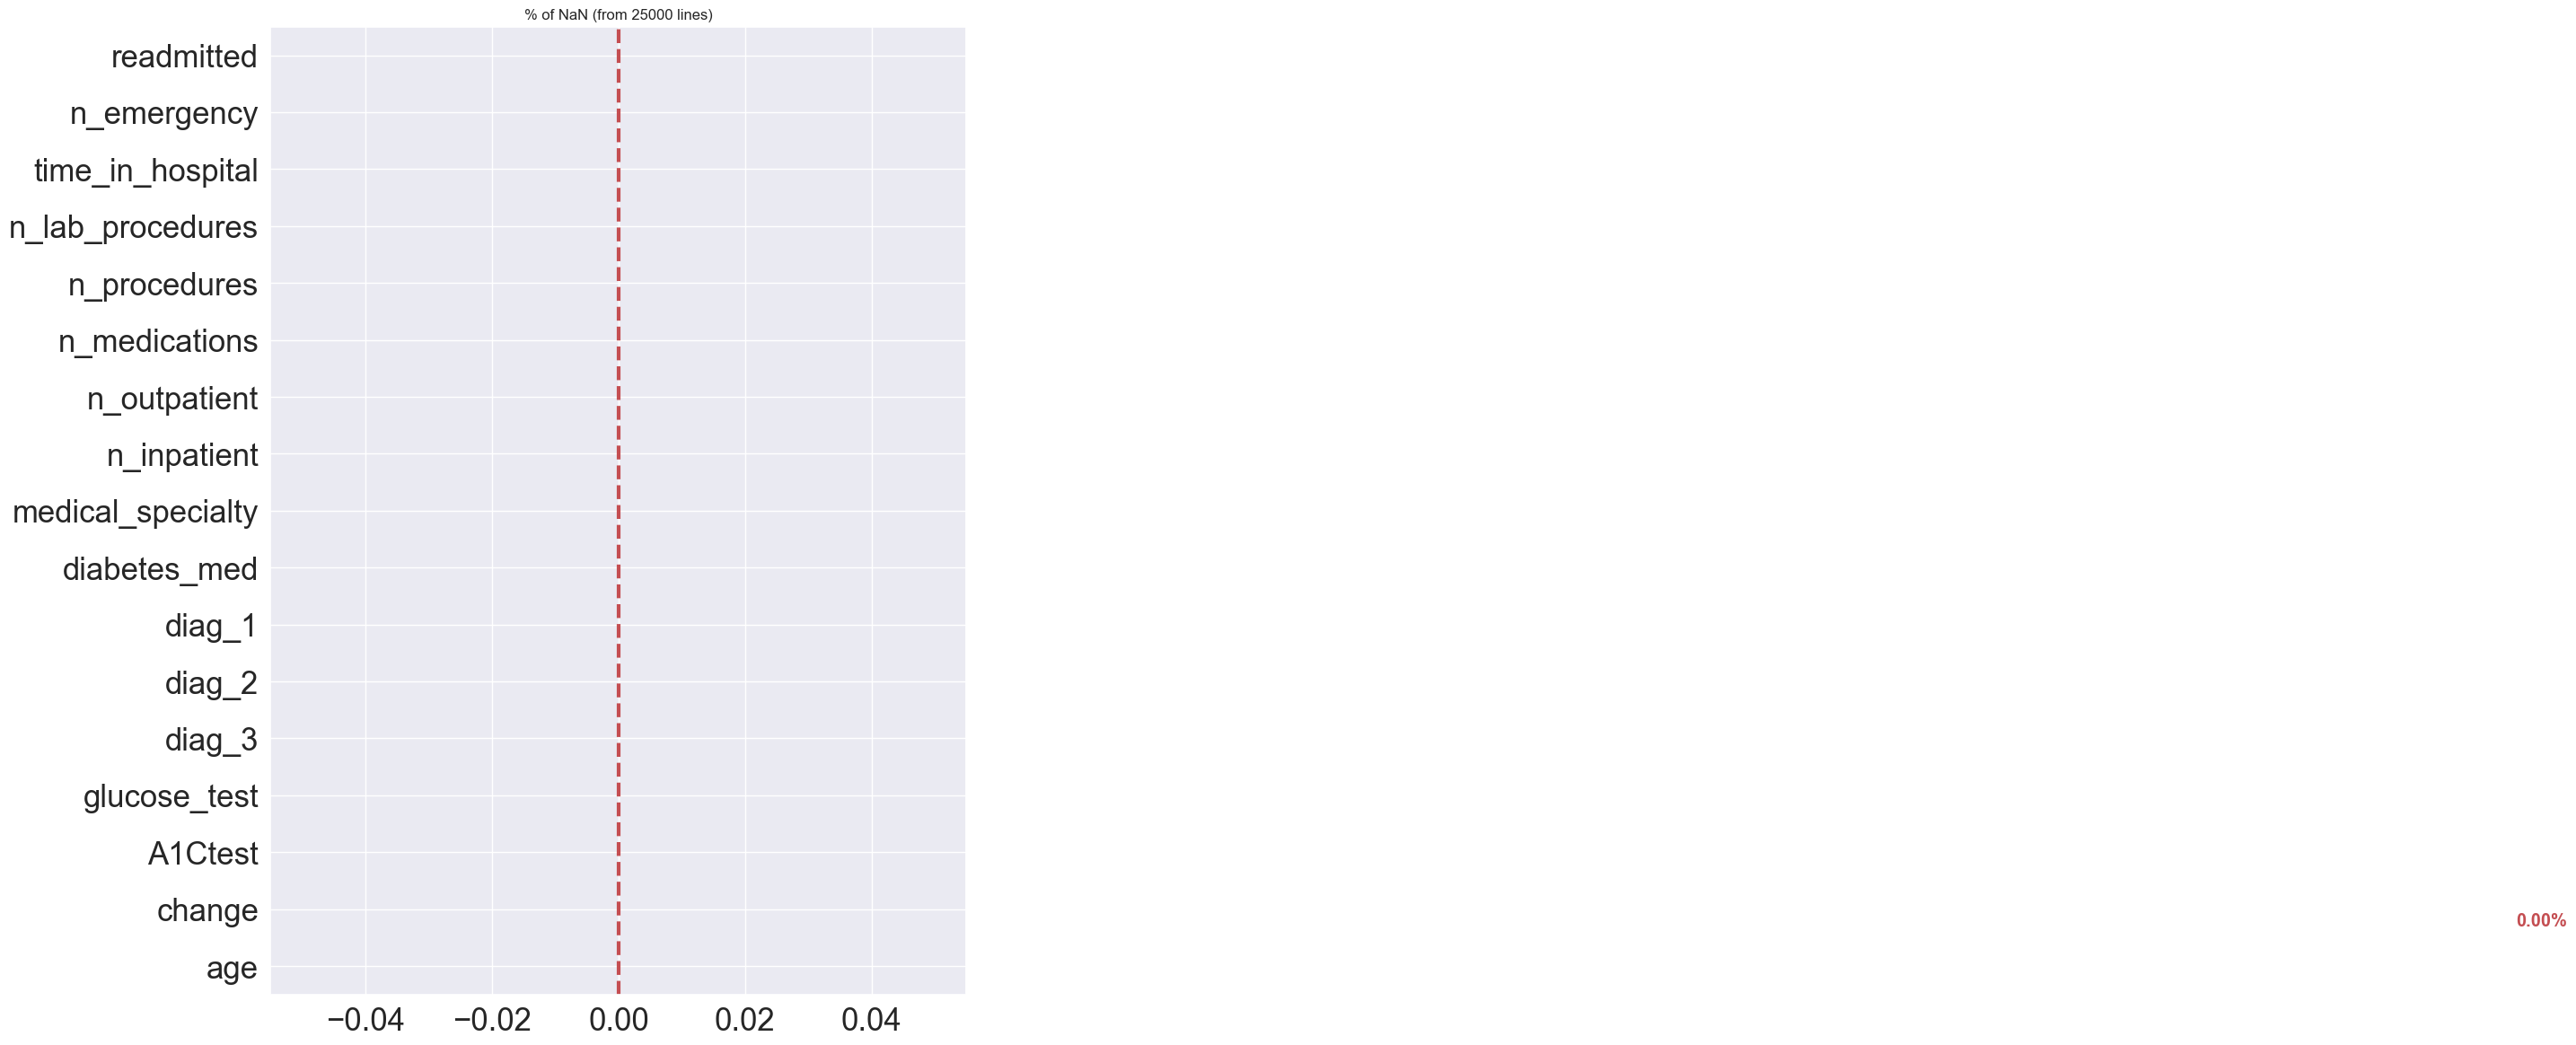

In [158]:
plot, threshold = percent_hbar(df)


#### We are faced with a successful plot that there are no gaps in our data. Let's look at the data itself in more detail

In [159]:
df.drop_duplicates()
display(df.info())
display(df.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   age                25000 non-null  object
 1   time_in_hospital   25000 non-null  int64 
 2   n_lab_procedures   25000 non-null  int64 
 3   n_procedures       25000 non-null  int64 
 4   n_medications      25000 non-null  int64 
 5   n_outpatient       25000 non-null  int64 
 6   n_inpatient        25000 non-null  int64 
 7   n_emergency        25000 non-null  int64 
 8   medical_specialty  25000 non-null  object
 9   diag_1             25000 non-null  object
 10  diag_2             25000 non-null  object
 11  diag_3             25000 non-null  object
 12  glucose_test       25000 non-null  object
 13  A1Ctest            25000 non-null  object
 14  change             25000 non-null  object
 15  diabetes_med       25000 non-null  object
 16  readmitted         25000 non-null  objec

None

time_in_hospital  n_lab_procedures  ...   n_inpatient   n_emergency
count       25000.00000       25000.00000  ...  25000.000000  25000.000000
mean            4.45332          43.24076  ...      0.615960      0.186600
std             3.00147          19.81862  ...      1.177951      0.885873
min             1.00000           1.00000  ...      0.000000      0.000000
25%             2.00000          31.00000  ...      0.000000      0.000000
50%             4.00000          44.00000  ...      0.000000      0.000000
75%             6.00000          57.00000  ...      1.000000      0.000000
max            14.00000         113.00000  ...     15.000000     64.000000

[8 rows x 7 columns]

In [160]:
variables = pd.DataFrame(columns=['Variable','Number of unique values','Values'])

for i, var in enumerate(df.columns):
    variables.loc[i] = [var, df[var].nunique(), df[var].unique().tolist()]
variables.set_index('Variable', inplace=True)    
variables

Number of unique values                                             Values
Variable                                                                                     
age                                      6  [[70-80), [50-60), [60-70), [40-50), [80-90), ...
time_in_hospital                        14    [8, 3, 5, 2, 1, 4, 7, 10, 6, 12, 11, 9, 14, 13]
n_lab_procedures                       109  [72, 34, 45, 36, 42, 51, 44, 19, 67, 37, 35, 6...
n_procedures                             7                              [1, 2, 0, 6, 3, 5, 4]
n_medications                           70  [18, 13, 12, 7, 10, 21, 16, 6, 26, 20, 11, 27,...
n_outpatient                            23  [2, 0, 1, 3, 7, 5, 4, 6, 9, 8, 11, 10, 15, 21,...
n_inpatient                             16  [0, 2, 3, 1, 6, 9, 7, 4, 5, 8, 10, 11, 14, 12,...
n_emergency                             21  [0, 1, 10, 2, 3, 4, 5, 7, 6, 12, 8, 16, 28, 18...
medical_specialty                        7  [Missing, Other, InternalMedicine, Family/Gene...
diag_1                                   8  [Circulatory, Other, Injury, Digestive, Respir...
diag_2                                   8  [Respiratory, Other, Circulatory, Injury, Diab...
diag_3                                   8  [Other, Circulatory, Diabetes, Respiratory, In...
glucose_test                             3                                 [no, normal, high]
A1Ctest                                  3                                 [no, normal, high]
change                                   2                                          [no, yes]
diabetes_med                             2                                          [yes, no]
readmitted                               2                                          [no, yes]

In [161]:
columns = ['age', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'glucose_test',
       'A1Ctest', 'change', 'diabetes_med', 'readmitted']
for col in columns:
    df[col] = df[col].astype('category')

In [162]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   age                25000 non-null  category
 1   time_in_hospital   25000 non-null  int64   
 2   n_lab_procedures   25000 non-null  int64   
 3   n_procedures       25000 non-null  int64   
 4   n_medications      25000 non-null  int64   
 5   n_outpatient       25000 non-null  int64   
 6   n_inpatient        25000 non-null  int64   
 7   n_emergency        25000 non-null  int64   
 8   medical_specialty  25000 non-null  category
 9   diag_1             25000 non-null  category
 10  diag_2             25000 non-null  category
 11  diag_3             25000 non-null  category
 12  glucose_test       25000 non-null  category
 13  A1Ctest            25000 non-null  category
 14  change             25000 non-null  category
 15  diabetes_med       25000 non-null  category
 16  read

#### We saw that we are already dealing with preprocessed data, since there are no missing values, all data has no visible errors. We have also transferred some of our data to a categorical type, we still need to think about how to make the view more comfortable for perception, and assign convenient values. I propose in the next chapter to take into account all the nuances of the dataframe and look at the primary analysis, as well as to start performing the tasks that have been completed in the work.

# Part 2: Exploratory Data Analysis


In [163]:
df.insert(0, 'age_cat', df.age)
char_to_replace = {'[70-80)': 'below_80',
                   '[60-70)': 'below_70',
                   '[80-90)': 'below_90',
                   '[50-60)': 'below_60',
                   '[40-50)': 'below_50',
                   '[90-100)': 'upper_90 '}
for key, value in char_to_replace.items():
    df.age_cat = df.age_cat.replace(key, value)
df.head()

age_cat      age  time_in_hospital  ...  change  diabetes_med  readmitted
0  below_80  [70-80)                 8  ...      no           yes          no
1  below_80  [70-80)                 3  ...      no           yes          no
2  below_60  [50-60)                 5  ...     yes           yes         yes
3  below_80  [70-80)                 2  ...     yes           yes         yes
4  below_70  [60-70)                 1  ...      no           yes          no

[5 rows x 18 columns]

#### Since we have an age step equal to 10 years, such a designation of the categorical age variable is applicable and we will proceed to our analysis, and if we understand in the process that some adjustments are needed, then we will return to this subparagraph

## 1. What is the most common primary diagnosis by age group? 


In [164]:
def barplot(df,X,Y,color,flag,xlabel,ylabel,title):
    n = list(df[X])
    s = list(df[Y].astype(int))
    c = list(df[color])
    total = sum(s)
    plt.figure(figsize=(16, 10))
    plt.xticks(rotation=75, fontsize=12);
    ax = plt.bar(n,s,edgecolor='black',linewidth=3,
        color=['g','r', 'y','b', 'c', 'w',],label=color)
    plt.title(title,fontsize=20)
    plt.xlabel(xlabel,fontsize = 16)
    plt.ylabel(ylabel,fontsize = 16)
    for i in range(len(s)):
        plt.annotate(str(s[i]), xy=(n[i],s[i]), ha='center', va='bottom',rotation=0,fontsize = 18)

        plt.annotate(str(c[i]), xy=(n[i],s[i]//2), ha='center', va='top',rotation=0,fontsize = 18 )
        if flag==1:
            plt.annotate(str(int(100*(s[i]/total)))+'%'+" of common", xy=(n[i],s[i]/1.1),
                         ha='center', va='top',rotation=0,fontsize = 13 )


    for i in range(len(s),len(s)):
        ax.patches[i].set_facecolor('#aa3333')
    plt.show()
    
    return  

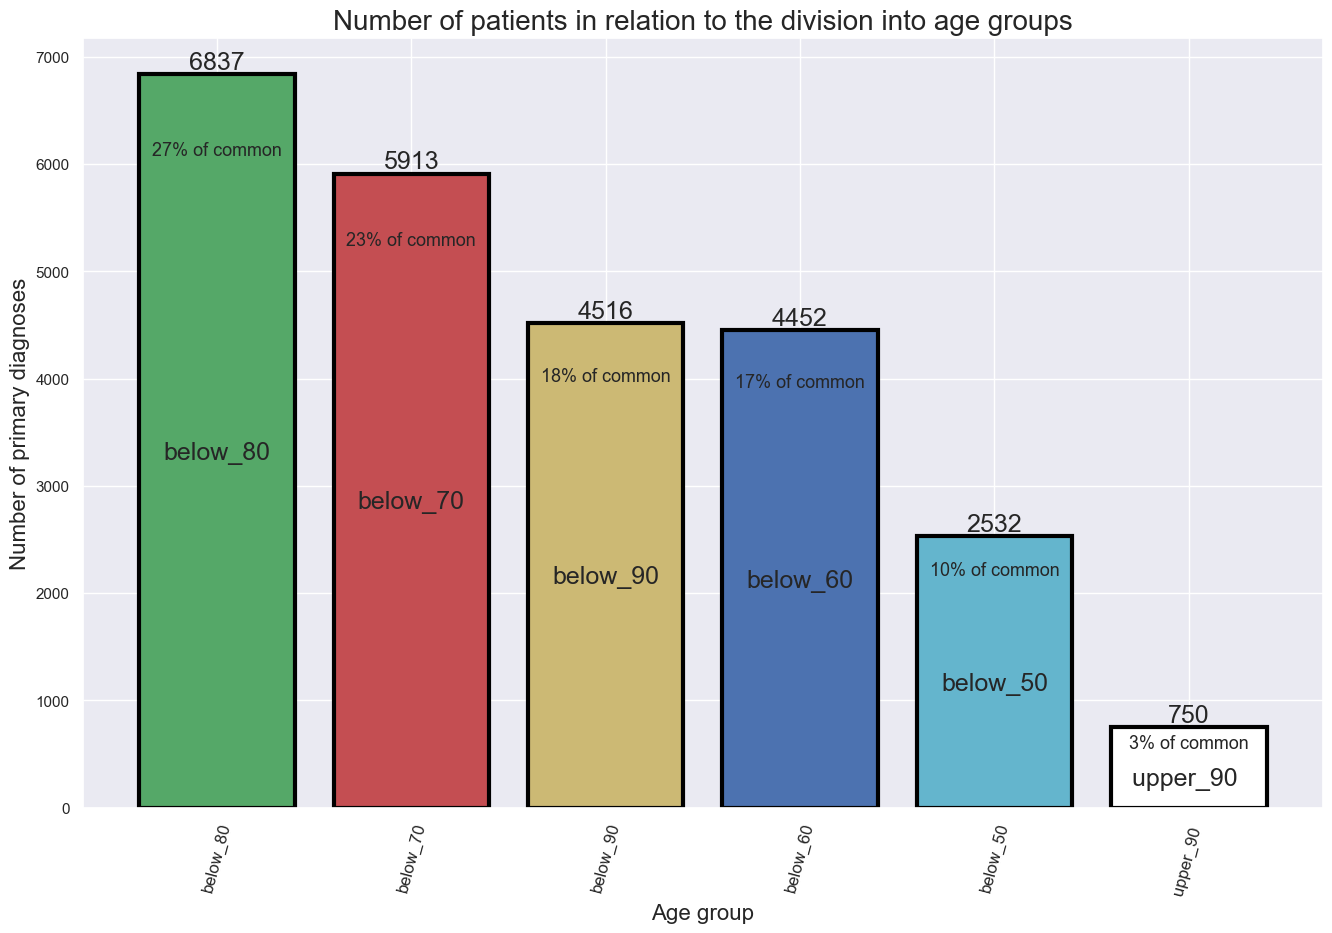

In [165]:
all_ = df.groupby(['age_cat'])\
         .agg('count').sort_values('age',ascending = False)\
         .rename(columns = {'age':'count'}).reset_index()[['age_cat','count']]
barplot(all_,'age_cat','count','age_cat',1,'Age group','Number of primary diagnoses','Number of patients in relation to the division into age groups')


In [166]:
df1 = df.groupby(['diag_1','age_cat'])['age_cat'].agg(['count'])\
        .reset_index().set_index('age_cat').sort_values(by='diag_1', ascending=False)

fig = px.bar(df1, title='Primary diagnosis relative to the age group', y='count', color='diag_1', height=500, text_auto=True)

fig.update_layout(yaxis_title='Number of primary diagnoses', xaxis_title='', autosize=False, width=1050,height=800,)
fig.update_coloraxes(colorbar_ticklabelposition='inside',colorbar_ticks='inside',showscale=False)
fig.update_traces(hovertemplate='%{x}   %{y} ',marker_line_color='black', marker_line_width=2.0)
fig.show()

In [167]:
first = df.groupby(['age_cat','diag_1'])\
          .agg('count').sort_values('age',ascending = False)\
          .rename(columns = {'age':'count'}).reset_index()[['age_cat','diag_1','count']]

ind_list = [0,1,3,6,10,31]
top_diag = first.iloc[ind_list]


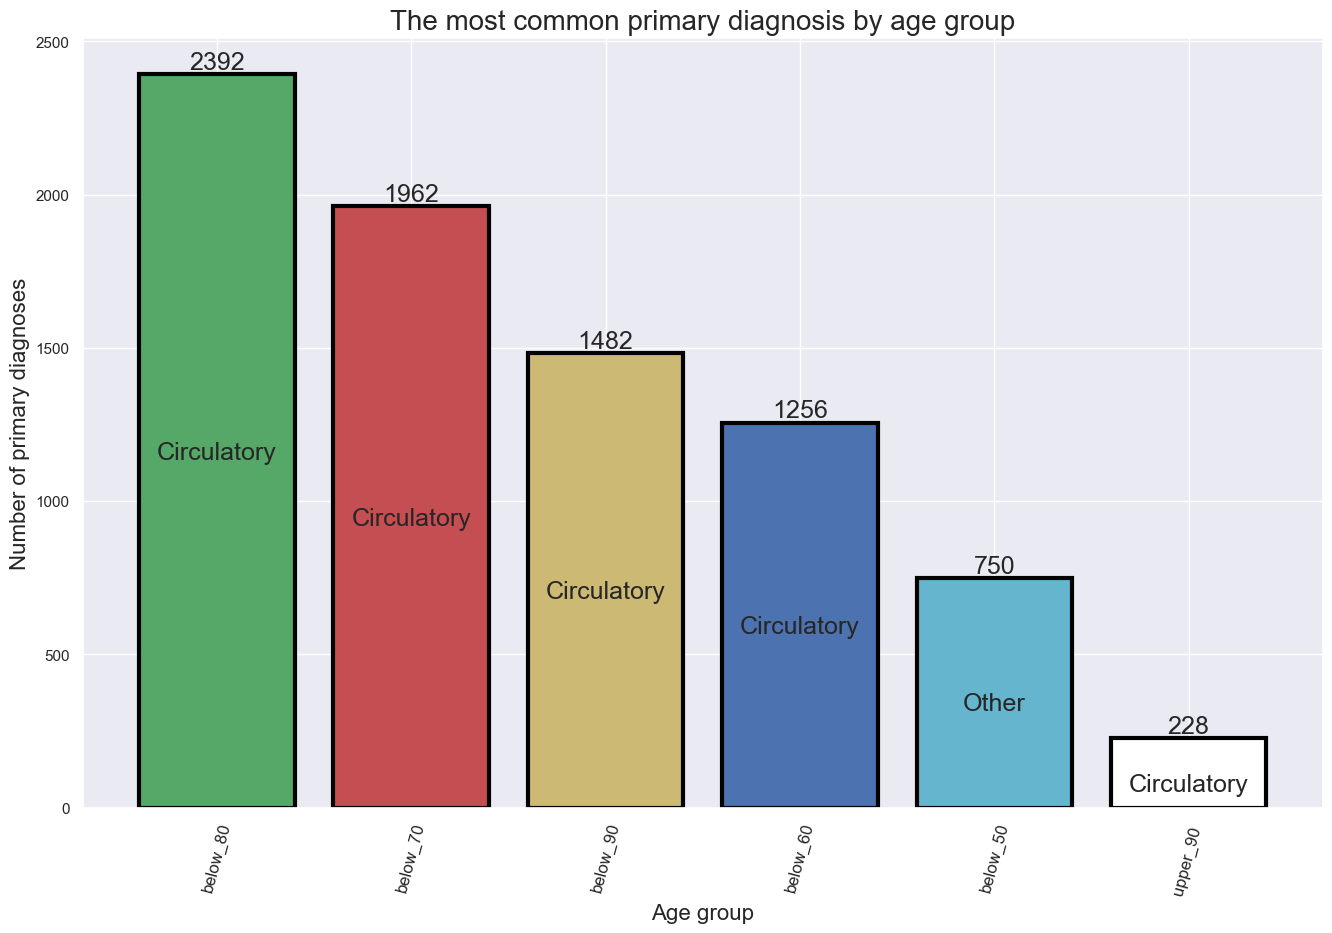

In [168]:
barplot(top_diag,'age_cat','count','diag_1',0,'Age group','Number of primary diagnoses','The most common primary diagnosis by age group')

### We have built three graphs:
	1. shows how many primary diagnoses were made in relation to age groups;
	2. the second informative one, where you can see in detail the entire breakdown by all ages of all primary diagnoses;
	3. third displays the most common diagnosis by age;

### From the latest graphs, we can draw several conclusions that the most common diagnosis is "circulation"; in patients younger than 50, this is the second most popular diagnosis. Depending on the group, on average, this diagnosis accounts for about 20-30% of the total number of referrals. The second most popular primary diagnosis refers to the "other" group and the third to respiratory diseases.

### 50% of all patients fall into two groups, these are patients:
 	from 70 to 80 of such patients 6837
	from 60 to 70 of such patients 5913

## 2. Some doctors believe diabetes might play a central role in readmission. Explore the effect of a diabetes diagnosis on readmission rates.

In [169]:
plot = df.groupby('readmitted').count().reset_index()[['readmitted','age_cat','age']]\
         .rename(columns = {'age_cat':'count','age':'%_of_total_count'})
plot['%_of_total_count'] = 100*((plot['%_of_total_count']/25000).round(2))


### Patients were divided almost equally, 47% of patients had repeated visits to the hospital. Let's look at these people in more detail and in a separate dataframe.

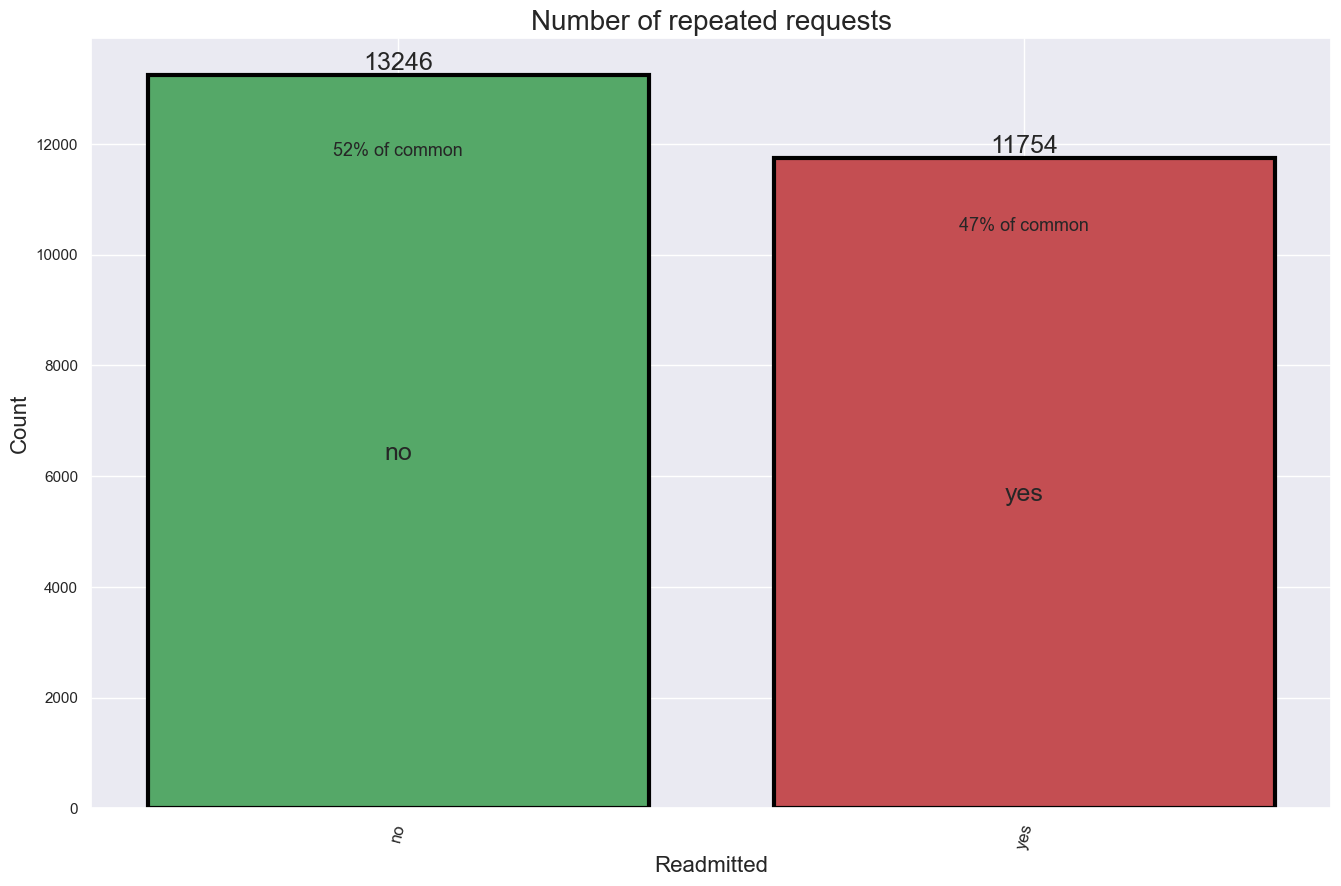

In [170]:
barplot(plot,'readmitted','count','readmitted',1,'Readmitted','Count','Number of repeated requests')

### It is necessary to understand the meaning of the question, or rather why there are two clarifying factors in it: 
	1. the impact of diabetes 
    2. re-hospitalization
#### Why exactly does diabetes have an impact on re-hospitalization and what is the purpose of the clinic under the concept of re-hospitalization.
#### These nuances gave food for thought and an impetus to find an answer to them, and after reading several scientific articles, I began to understand why re-hospitalization is so important for hospitals
## Now I will try to convey this information


  Repeated hospitalization makes an important contribution to the overall medical costs and is an indicator of the quality of medical care. Diabetes, like other chronic diseases, is associated with an increased risk of re-hospitalization. Risk factors include previous hospitalization, extreme age, and socio-economic barriers. Acute or chronic glycemic control may be important when diabetes is the primary diagnosis or when it is a concomitant pathology.
  
  A significant share of hospital expenses is accounted for by a small percentage of patients, especially patients with chronic diseases. These costs are largely related to repeated hospitalizations for the same condition. More and more attention is being paid to preventing unplanned re-hospitalization as one of the ways to reduce hospital costs.
  
#### In one of the articles I found the above cost calculation:
	The estimated cost of diabetes in 2007 was $174 billion, with the largest costs coming from inpatient treatment. The cost 
    of patient with diabetes was estimated to be 2.3 times higher than that of a patient without diabetes. It has been 
    reported that in elderly patients with diabetes, 56% of the costs are accounted for by 10% of patients, and these costs
    are largely related to hospitalization. Complications of diabetes were associated with increased costs.
  
 ### From the listed facts, it becomes clear why increased attention is paid to these factors in this matter.

### Probably, in order to correctly answer the question correctly, it is necessary to consider two sets of data both from repeated hospitalization and not and evaluate in both cases the impact of the diagnosis of diabetes on the number of patients

A small moment for revelations: at this very moment of my work, I got into a stupor, because there is a slight misunderstanding of the question "study the impact of the diagnosis of diabetes.....". But if we turn to the data, we have three types of diagnosis and there is diabetes everywhere, and "what should we do"?

## How do we understand which diagnosis we should take as a basis for the first or second , and maybe the third, or even only those where all three diagnoses agree in one opinion?

At that moment, I did not yet understand which branch of analysis to start developing, and I am once again convinced that simply data without feedback becomes less useful if you cannot ask a question and get an answer to it.

After some time, after walking around the room and thinking about everything properly, I decided that it would be more correct to consider a data set in which there is at least one of the three diagnoses of diabetes


In [171]:
diabetes = df.query('readmitted =="yes" ')\
             .groupby(['diag_1','diag_2','diag_3']).count().reset_index()\
             .query('diag_1 =="Diabetes" or diag_2 =="Diabetes"or diag_3 =="Diabetes"')\
             .rename(columns={'age':'count','time_in_hospital':'%_of_common'})[['diag_1','diag_2','diag_3','count','%_of_common']]\
             .sort_values('count',ascending= False)\
             .query('count >0')
diabetes['%_of_common'] = ((diabetes['%_of_common']/11754)*100).round(2)

In [172]:
diabetes.head()

diag_1       diag_2       diag_3  count  %_of_common
1    Circulatory  Circulatory     Diabetes    383         3.26
118     Diabetes        Other        Other    290         2.47
433        Other        Other     Diabetes    285         2.42
8    Circulatory     Diabetes  Circulatory    189         1.61
49   Circulatory        Other     Diabetes    184         1.57

In [173]:
total_count = diabetes['%_of_common'].sum()
total_common_count = (100*(diabetes['count'].sum()/25000)).round(1)
print (f'The percentage of re-hospitalized with a diagnosis of diabetes is  {total_count}%.')
print (f'Percentage of those hospitalized with a diagnosis of diabetes from the total number  {total_common_count}%.')

The percentage of re-hospitalized with a diagnosis of diabetes is  34.9%.
Percentage of those hospitalized with a diagnosis of diabetes from the total number  16.4%.


### By choosing that the diagnosis of diabetes was present in at least one of the three columns with data on the diagnosis and filtering the data so that only those patients who were confirmed for re-hospitalization remained, we received a separate dataframe in which 35% of patients (of the total number with re-hospitalization) have at least one of the three diagnoses of Diabetes.

## A third of all re-hospitalized patients have a diagnosis of Diabetes in their medical records.



In [174]:
diabetes_ = df.groupby(['readmitted','diag_1','diag_2','diag_3']).count().reset_index()\
                     .query('diag_1 =="Diabetes" or diag_2 =="Diabetes"or diag_3 =="Diabetes"')\
                     .rename(columns={'age':'count','time_in_hospital':'%_of_common'})[['readmitted','diag_1','diag_2','diag_3','count','%_of_common']].sort_values('count',ascending= False)

diabetes_['%_of_common'] = ((diabetes_['%_of_common']/len(df))*100).round(2)

fig = px.sunburst(diabetes_,title='Percentage of patients with different diagnoses during and without readmission (interactive pie chart)', path=['readmitted','diag_1', 'diag_2','diag_3'], values='count',height=800, color ='diag_1',color_discrete_map={'(?)':'green', })

fig.update_traces(marker_line_color='black', marker_line_width=.5)

fig.show()


In [175]:
df2 = df.groupby(['readmitted','diag_1']).count().reset_index()[['diag_1','readmitted','age_cat','age']]\
        .rename(columns = {'age_cat':'count','age':'%_of_total_count'})\
        .sort_values('count',ascending= False)
df2['%_of_total_count'] = 100*((df2['%_of_total_count']/25000).round(2))


In [176]:
def stacked_bar(x,y,data, series_labels, category_labels=None, 
                     show_values=False, value_format="{}",title=None, y_label=None, 
                     colors=None, grid=True, reverse=False):
    plt.figure(figsize=(x, y))
    plt.title(title,fontsize=20)

    ny = len(data[0])
    ind = list(range(ny))
    axes = []
    cum_size = np.zeros(ny)
    data = np.array(data)
    if reverse:
        data = np.flip(data, axis=1)
        category_labels = reversed(category_labels)
    for i, row_data in enumerate(data):
        color = colors[i] if colors is not None else None
        axes.append(plt.bar(ind, row_data, bottom=cum_size, 
                            label=series_labels[i], color=color,edgecolor='black',linewidth=3,))
    
        cum_size += row_data
    if category_labels:
        plt.xticks(ind, category_labels,fontsize = 16)
    if y_label:
        plt.ylabel(y_label,fontsize = 18)
    plt.legend()
    if grid:
        plt.grid()
    if show_values:
        for axis in axes:
            for bar in axis:
                w, h = bar.get_width(), bar.get_height()
                plt.text(bar.get_x() + w/2, bar.get_y()+h , 
                         value_format.format(h), ha="center", 
                         va='bottom',fontsize = 18)
                
                

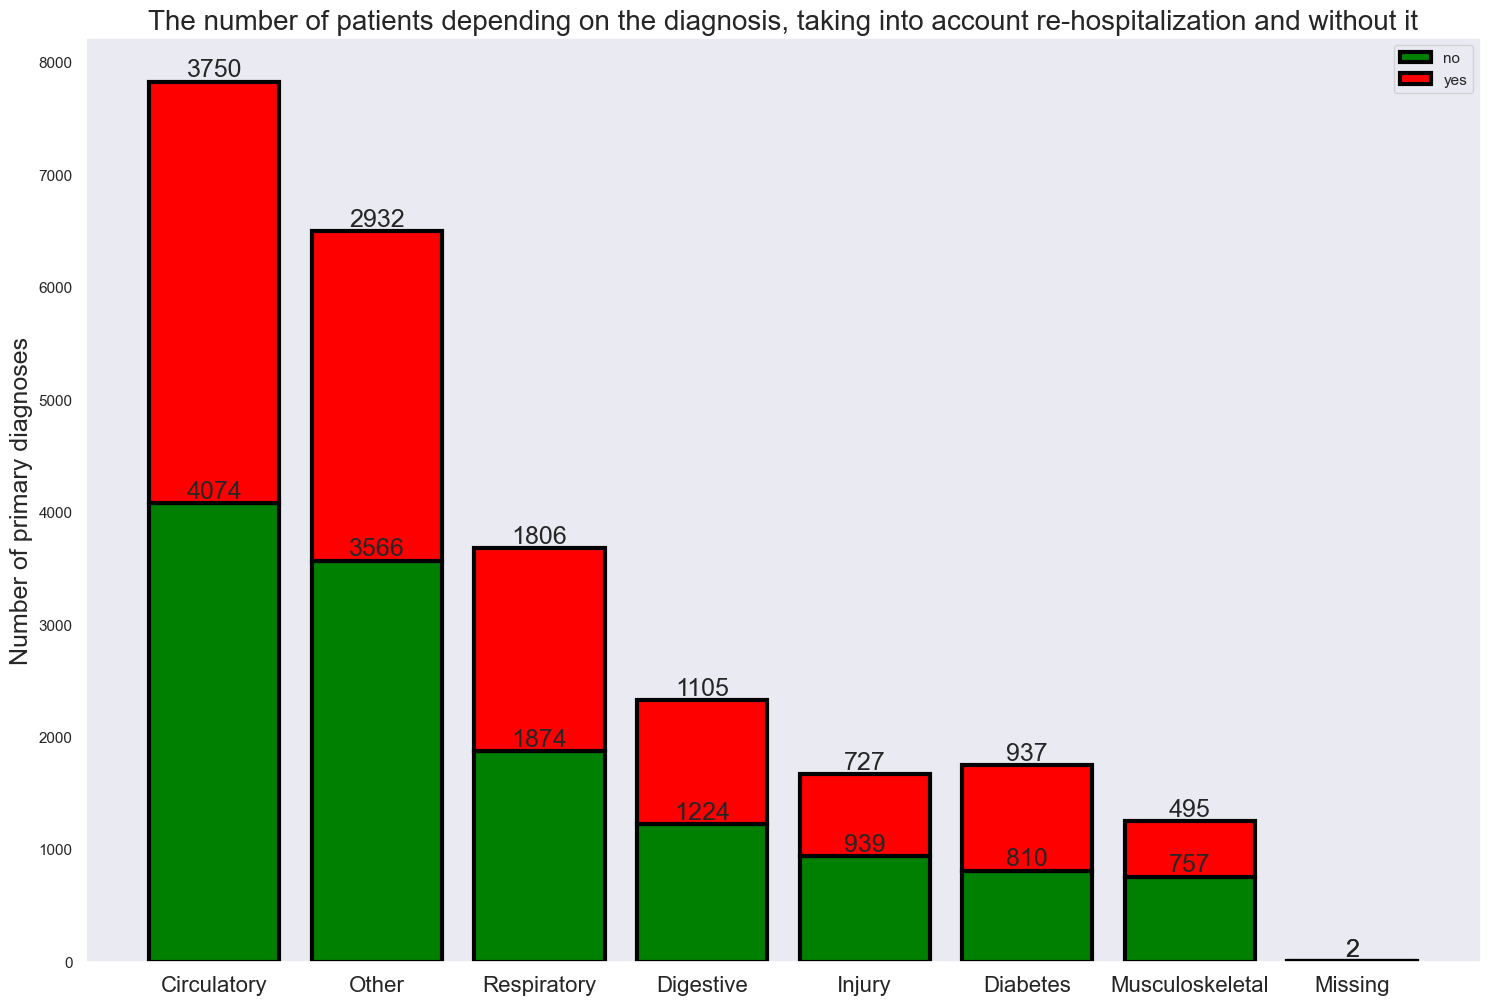

In [177]:
series_labels = df2.readmitted.unique()
s1 = list(df2.query('readmitted=="no"')['count'])
s2 = list(df2.query('readmitted=="yes"')['count'])
s2[4], s2[5] = s2[5], s2[4]
data = [s1,s2]

category_labels = list(df2.query('readmitted=="no"')['diag_1'])
stacked_bar(18,12,
    data, 
    series_labels, 
    category_labels=category_labels, 
    show_values=True, 
    value_format="{:.0f}",
    title = 'The number of patients depending on the diagnosis, taking into account re-hospitalization and without it',
    colors=['green', 'red'],
    y_label="Number of primary diagnoses")

plt.show()

### The last graph gives us a good idea of both diagnoses and re-hospitalization. It can be seen that the number of patients without hospitalization in all diagnoses is greater than in repeated, in all but one - "diabetes"!

**This is the only diagnosis where the number of repeated hospitalizations exceeds let's try to figure out why this is happening.**

### We only looked at the result of the initial diagnosis, but what. it will be if the primary diagnosis is different and the rest confirm diabetes . Let's look at the data where again at least one of the three diagnoses was diabetes and build the dependence of hospitalization on the other columns of our data

In [178]:
diab = df.query('diag_1 =="Diabetes" or diag_2 =="Diabetes" or diag_3 =="Diabetes"')


### And what if we look at what other diagnoses are more common with diabetes

In [179]:
diab_readm_yes = diab[diab['readmitted']=='yes']
diab_readm_no = diab[diab['readmitted']=='no']

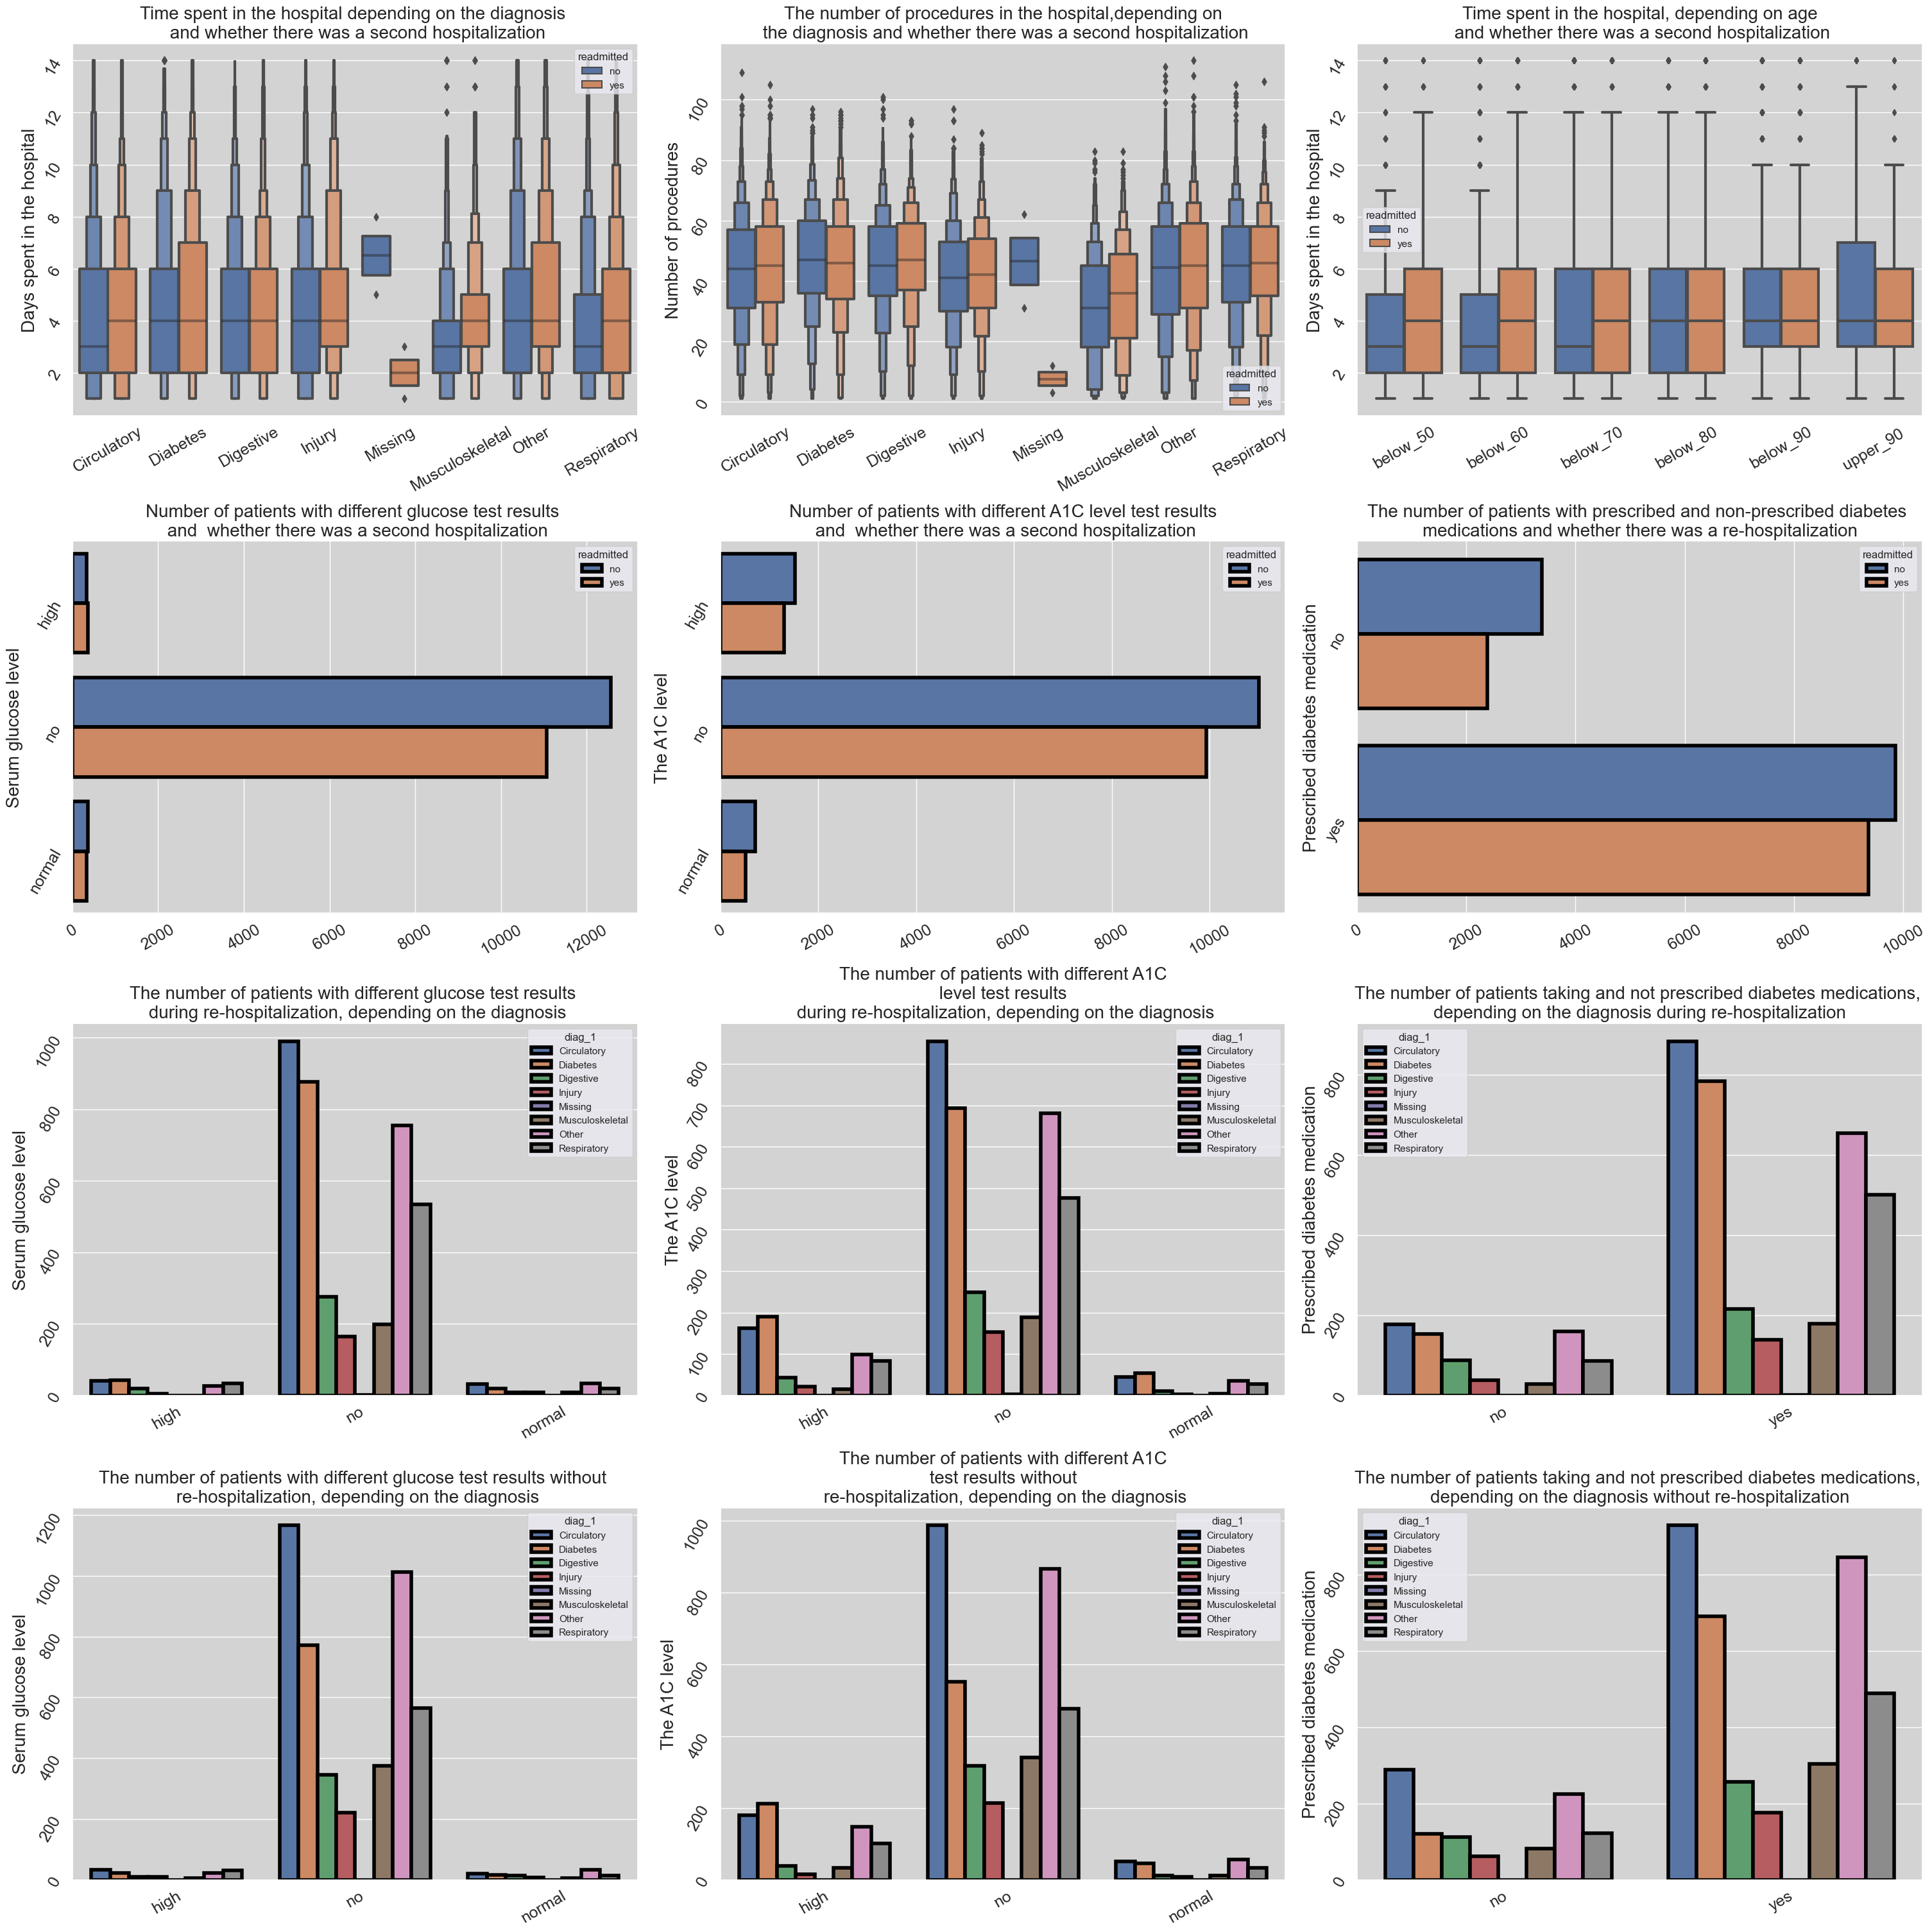

In [180]:
fig, axes = plt.subplots(nrows=4, ncols=3,figsize=(30, 30),constrained_layout=True)
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=30,fontsize=18)
    plt.yticks(rotation=60,fontsize=18)
    ax.set(facecolor = 'lightgray')
# first row
sns.boxenplot(y='time_in_hospital', x= "diag_1",hue = 'readmitted', data=df,ax = axes[0,0],linewidth=3,  )
sns.boxenplot(y='n_lab_procedures', x= "diag_1",hue = 'readmitted', data=df,ax = axes[0,1],linewidth=3,  )
sns.boxplot(y='time_in_hospital', x= "age_cat",hue = 'readmitted', data=df,ax = axes[0,2], linewidth=3,  )

axes[0,0].set_title("Time spent in the hospital depending on the diagnosis \n and whether there was a second hospitalization", fontsize=20,loc = 'center');
axes[0,1].set_title("The number of procedures in the hospital,depending on\n the diagnosis and whether there was a second hospitalization", fontsize=20,loc = 'center');
axes[0,2].set_title("Time spent in the hospital, depending on age\n and whether there was a second hospitalization", fontsize=20,loc = 'center');

axes[0,0].set_xlabel(None)
axes[0,1].set_xlabel(None)
axes[0,2].set_xlabel(None)

axes[0,0].set_ylabel('Days spent in the hospital',fontsize=20)
axes[0,1].set_ylabel('Number of procedures',fontsize=20)
axes[0,2].set_ylabel('Days spent in the hospital',fontsize=20)

# second row
sns.countplot(data=df,ax = axes[1,0], y="glucose_test", hue = 'readmitted',  linewidth=4, edgecolor="black", )
sns.countplot(data=df,ax = axes[1,1], y="A1Ctest", hue = 'readmitted',  linewidth=4, edgecolor="black", )
sns.countplot(data=df,ax = axes[1,2], y="diabetes_med", hue = 'readmitted',  linewidth=4, edgecolor="black",)

axes[1,0].set_title("Number of patients with different glucose test results \n and  whether there was a second hospitalization", fontsize=20,loc = 'center');
axes[1,1].set_title("Number of patients with different A1C level test results\n and  whether there was a second hospitalization", fontsize=20,loc = 'center');
axes[1,2].set_title("The number of patients with prescribed and non-prescribed diabetes \nmedications and whether there was a re-hospitalization", fontsize=20,loc = 'center');

axes[1,0].set_xlabel(None)
axes[1,1].set_xlabel(None)
axes[1,2].set_xlabel(None)

axes[1,0].set_ylabel('Serum glucose level',fontsize=20)
axes[1,1].set_ylabel('The A1C level',fontsize=20)
axes[1,2].set_ylabel('Prescribed diabetes medication',fontsize=20)

# third row
sns.countplot(data=diab_readm_yes,ax = axes[2,0], x="glucose_test", hue = 'diag_1',  linewidth=4, edgecolor="black",)
sns.countplot(data=diab_readm_yes,ax = axes[2,1], x="A1Ctest", hue = 'diag_1',  linewidth=4, edgecolor="black",)
sns.countplot(data=diab_readm_yes,ax = axes[2,2], x="diabetes_med", hue ='diag_1',  linewidth=4, edgecolor="black",)

axes[2,0].set_title("The number of patients with different glucose test results \n during re-hospitalization, depending on the diagnosis", fontsize=20,loc = 'center');
axes[2,1].set_title("The number of patients with different A1C\n level test results \n during re-hospitalization, depending on the diagnosis", fontsize=20,loc = 'center');
axes[2,2].set_title("The number of patients taking and not prescribed diabetes medications, \ndepending on the diagnosis during re-hospitalization", fontsize=20,loc = 'center');
axes[2,0].set_xlabel(None)
axes[2,1].set_xlabel(None)
axes[2,2].set_xlabel(None)

axes[2,0].set_ylabel('Serum glucose level',fontsize=20)
axes[2,1].set_ylabel('The A1C level',fontsize=20)
axes[2,2].set_ylabel('Prescribed diabetes medication',fontsize=20)

#fourth row
sns.countplot(data=diab_readm_no,ax = axes[3,1], x="A1Ctest", hue = 'diag_1',  linewidth=4, edgecolor="black",)
sns.countplot(data=diab_readm_no,ax = axes[3,0], x="glucose_test", hue = 'diag_1',  linewidth=4, edgecolor="black",)
sns.countplot(data=diab_readm_no,ax = axes[3,2], x="diabetes_med", hue ='diag_1',  linewidth=4, edgecolor="black",);

axes[3,0].set_title("The number of patients with different glucose test results without \n re-hospitalization, depending on the diagnosis", fontsize=20,loc = 'center');
axes[3,1].set_title("The number of patients with different A1C\n test results without \n re-hospitalization, depending on the diagnosis", fontsize=20,loc = 'center');
axes[3,2].set_title("The number of patients taking and not prescribed diabetes medications, \ndepending on the diagnosis without re-hospitalization", fontsize=20,loc = 'center');
axes[3,0].set_xlabel(None)
axes[3,1].set_xlabel(None)
axes[3,2].set_xlabel(None)

axes[3,0].set_ylabel('Serum glucose level',fontsize=20)
axes[3,1].set_ylabel('The A1C level',fontsize=20)
axes[3,2].set_ylabel('Prescribed diabetes medication',fontsize=20);


#### 1. Let's describe the results. With repeated hospitalization and diabetes, the number of days spent in the hospital is greater. In most cases, recovery comes within 2 to 7 days and a median value of 4 days. Without repeated hospitalization, recovery occurs from 2 to 6 days and the median is also 4 days.

#### 2. The number of procedures for different diagnoses is approximately the same regardless of the type of hospitalization. As I understand it, the actions of doctors and the tests prescribed by them practically do not depend on the type of hospitalization, but only on the diagnosis made to the patient.


#### 3. Patients from 40 to 60 years on average spend a couple of days more in the hospital during re-hospitalization. The remaining patients have approximately the same distribution in terms of hospitalization time, regardless of its type (whether there was a re-hospitalization or not)

#### 4. Most patients were not tested for glucose and A1C levels, but about 70% of patients were prescribed medications for diabetes.

#### 5. From the last rows of the graph, we can confidently conclude that there are four main diagnoses: circulatory system, diabetes, other diseases and respiratory diseases. As can be seen, the trend for re-hospitalization and without it persists for all diagnoses with the exception of only one. And oh yes, this diagnosis is DIABETES. On these graphs, we tried to understand how our data is distributed, and in the end we came across a solution to the second question. We know that the number of patients without re - hospitalization exceeds the number with re - hospitalization and the distribution of diagnoses gives us confirmation of this . But this point is not true for everyone, with fewer patients diagnosed with diabetes, the number of re-hospitalizations in this case is higher than in patients without re-hospitalization.
 
### We got the answer to the second question, but let's build this graph and see everything more clearly


## Before finally making sure of this, let's see how the rest of the diagnoses will behave with and without re-hospitalization

In [181]:
age = df.groupby(['diag_1','readmitted','age_cat']).count().rename(columns = {'age':'count'})['count'].reset_index()
glucose = df.groupby(['diag_1','readmitted','glucose_test']).count().rename(columns = {'age':'count'})['count'].reset_index()
a1ctest = df.groupby(['diag_1','readmitted','A1Ctest']).count().rename(columns = {'age':'count'})['count'].reset_index()


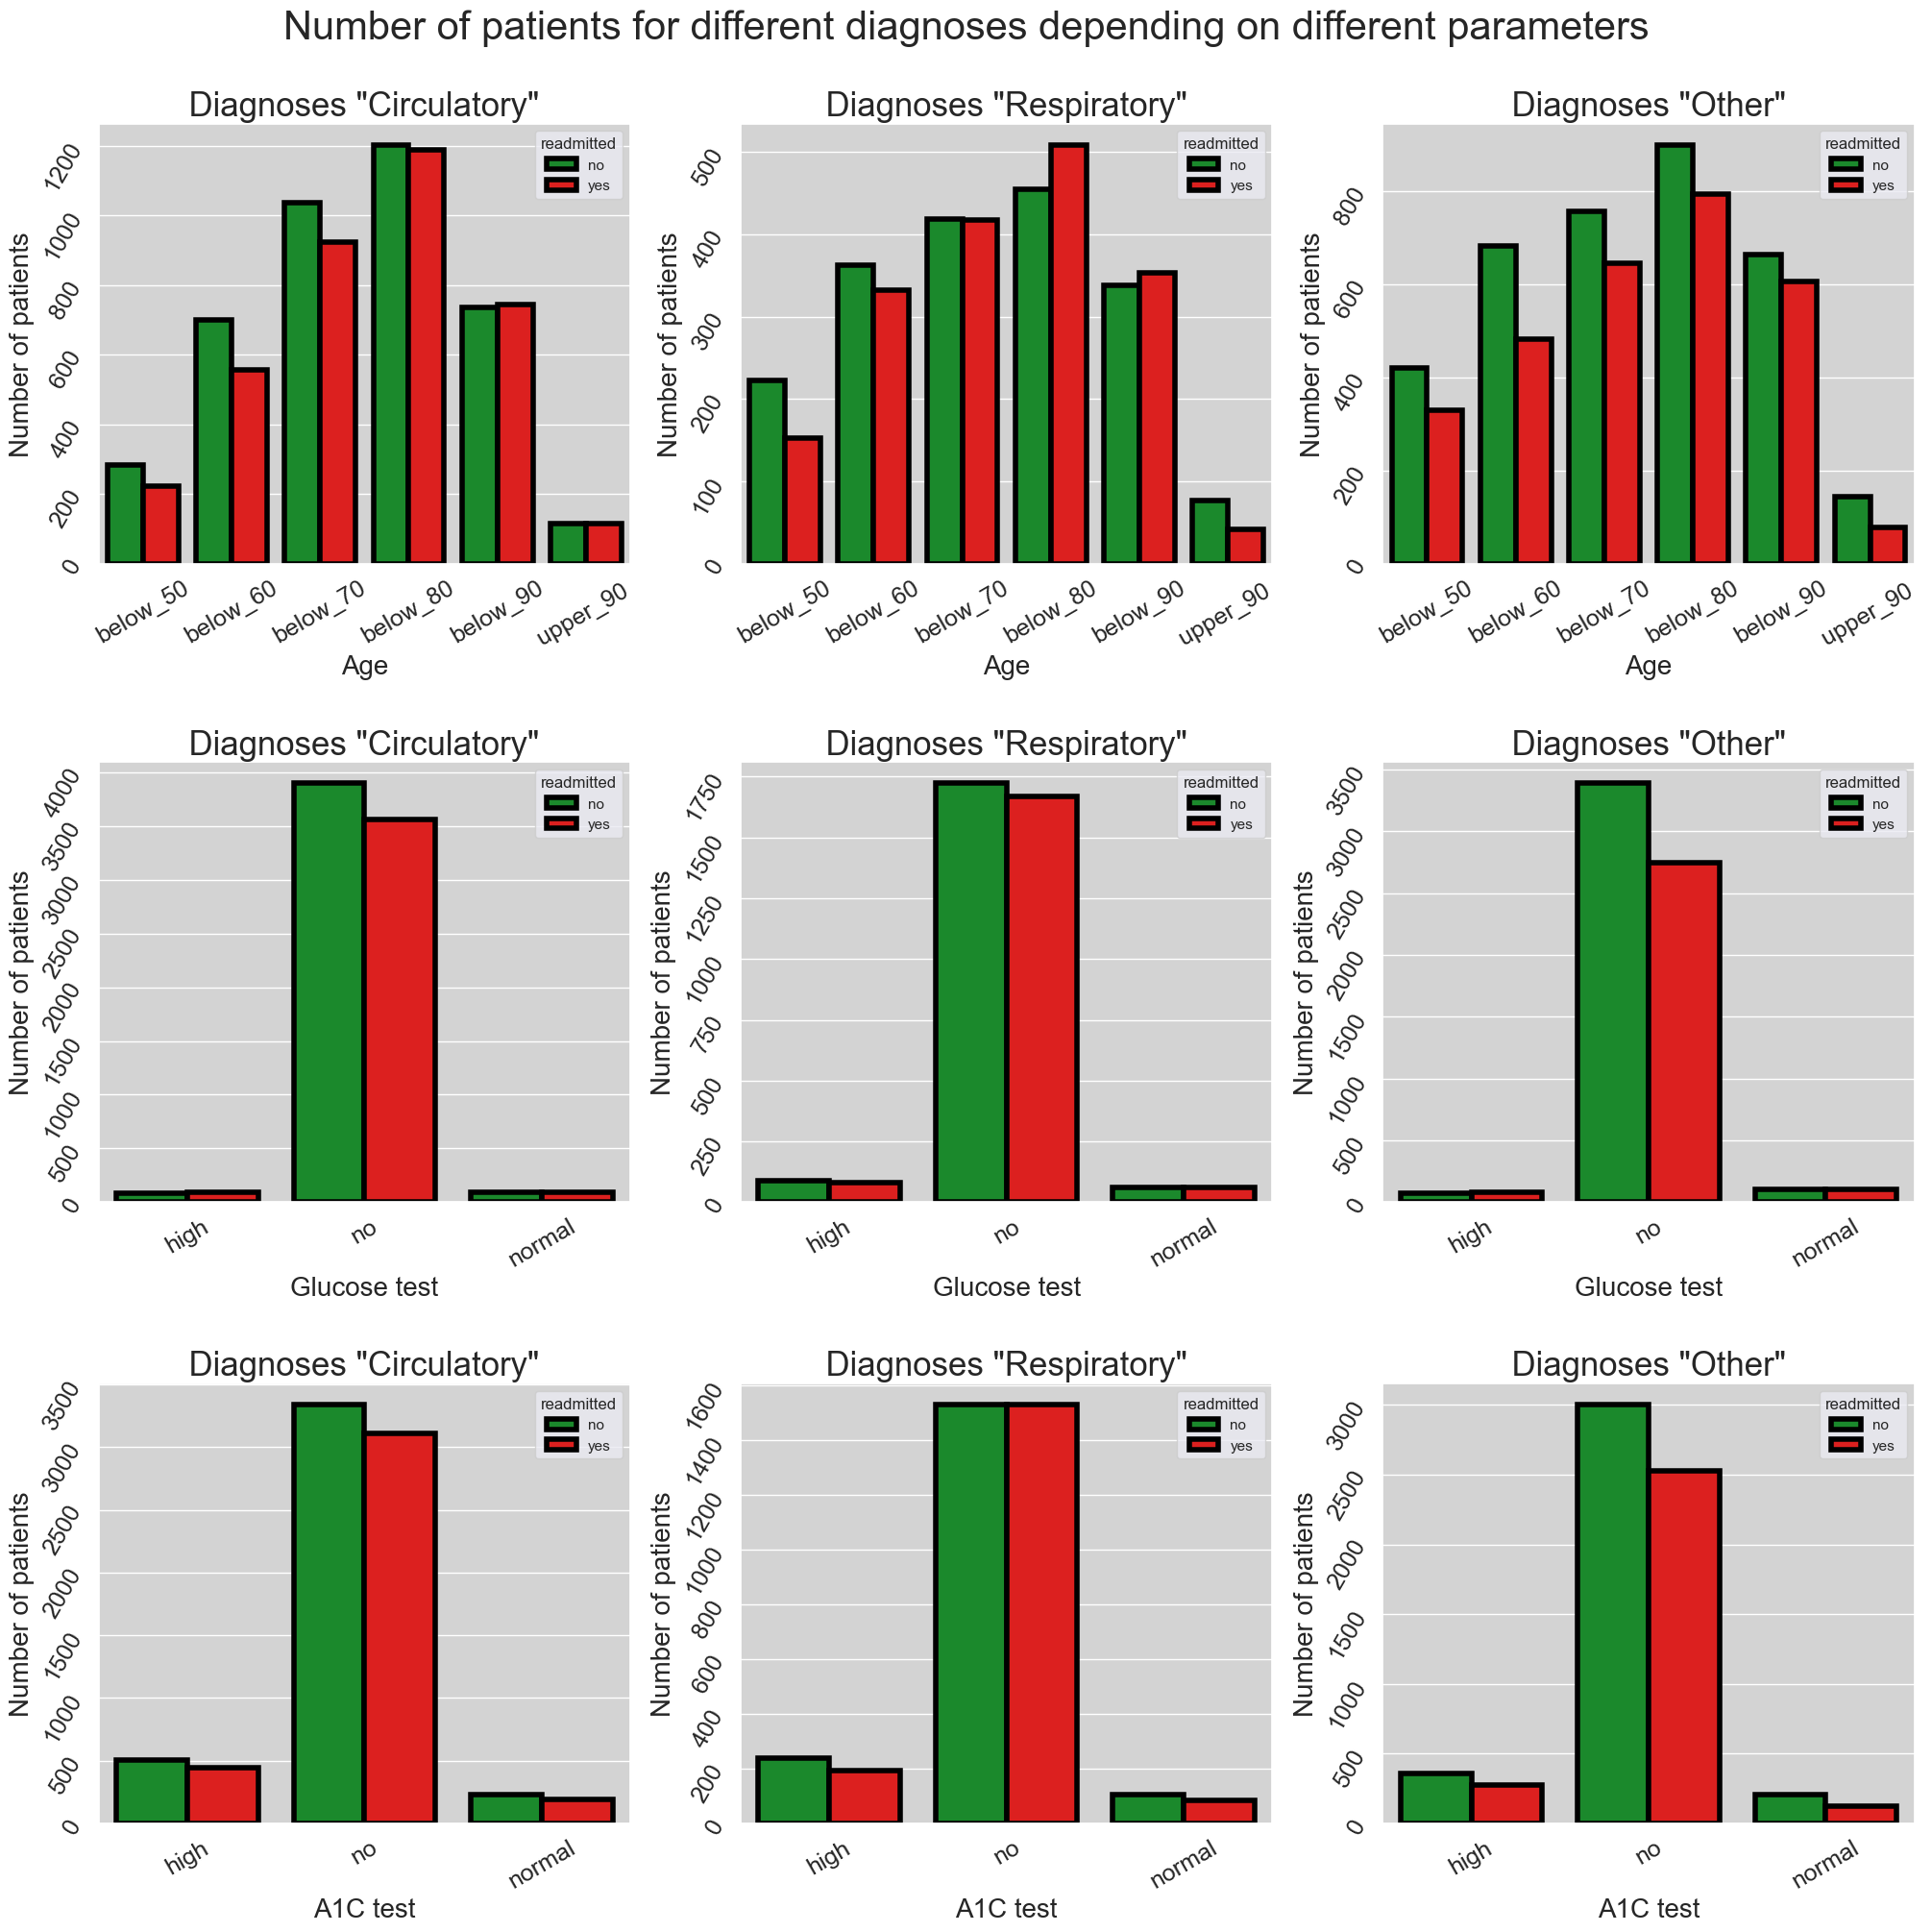

In [182]:
fig, axes = plt.subplots(nrows=3, ncols=3,figsize=(20, 20),constrained_layout=True)
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=30,fontsize=18)
    plt.yticks(rotation=60,fontsize=18)
    ax.set(facecolor = 'lightgray')
    
# First columns
sns.barplot(data = age.query('diag_1 =="Circulatory"'), x ='age_cat',ax= axes[0,0],
            y = 'count',hue = 'readmitted', palette= ['#099b1f','#fb0100'],linewidth=4, edgecolor="black",);

sns.barplot(data = age.query('diag_1 =="Respiratory"'), x ='age_cat',ax= axes[0,1],
            y = 'count',hue = 'readmitted', palette= ['#099b1f','#fb0100'],linewidth=4, edgecolor="black",);

sns.barplot(data = age.query('diag_1 =="Other"'), x ='age_cat',ax= axes[0,2],
            y = 'count',hue = 'readmitted', palette= ['#099b1f','#fb0100'],linewidth=4, edgecolor="black",);


fig.suptitle('Number of patients for different diagnoses depending on different parameters',fontsize=30)

axes[0,0].set_title('\n Diagnoses "Circulatory" ', fontsize=25,loc = 'center');
axes[0,1].set_title('\n Diagnoses "Respiratory" ', fontsize=25,loc = 'center');
axes[0,2].set_title('\n Diagnoses "Other" ', fontsize=25,loc = 'center');
axes[1,0].set_title('\n Diagnoses "Circulatory" ', fontsize=25,loc = 'center');
axes[1,1].set_title('\n Diagnoses "Respiratory" ', fontsize=25,loc = 'center');
axes[1,2].set_title('\n Diagnoses "Other" ', fontsize=25,loc = 'center');
axes[2,0].set_title('\n Diagnoses "Circulatory" ', fontsize=25,loc = 'center');
axes[2,1].set_title('\n Diagnoses "Respiratory" ', fontsize=25,loc = 'center');
axes[2,2].set_title('\n Diagnoses "Other" ', fontsize=25,loc = 'center');


axes[0,0].set_xlabel('Age',fontsize=20)
axes[0,1].set_xlabel('Age',fontsize=20)
axes[0,2].set_xlabel('Age',fontsize=20)
axes[0,0].set_ylabel('Number of patients',fontsize=20)
axes[0,1].set_ylabel('Number of patients',fontsize=20)
axes[0,2].set_ylabel('Number of patients',fontsize=20)


# Second. columns
sns.barplot(data = glucose.query('diag_1 =="Circulatory"'), x ='glucose_test',ax= axes[1,0],
            y = 'count',hue = 'readmitted', palette= ['#099b1f','#fb0100'],linewidth=4, edgecolor="black",);

sns.barplot(data = glucose.query('diag_1 =="Respiratory"'), x ='glucose_test',ax= axes[1,1],
            y = 'count',hue = 'readmitted', palette= ['#099b1f','#fb0100'],linewidth=4, edgecolor="black",);

sns.barplot(data = glucose.query('diag_1 =="Other"'), x ='glucose_test',ax= axes[1,2],
            y = 'count',hue = 'readmitted', palette= ['#099b1f','#fb0100'],linewidth=4, edgecolor="black",);

axes[1,0].set_xlabel('Glucose test',fontsize=20)
axes[1,1].set_xlabel('Glucose test',fontsize=20)
axes[1,2].set_xlabel('Glucose test',fontsize=20)
axes[1,0].set_ylabel('Number of patients',fontsize=20)
axes[1,1].set_ylabel('Number of patients',fontsize=20)
axes[1,2].set_ylabel('Number of patients',fontsize=20)


# third columns 

sns.barplot(data = a1ctest.query('diag_1 =="Circulatory"'), x ='A1Ctest',ax= axes[2,0],
            y = 'count',hue = 'readmitted', palette= ['#099b1f','#fb0100'],linewidth=4, edgecolor="black",);

sns.barplot(data = a1ctest.query('diag_1 =="Respiratory"'), x ='A1Ctest',ax= axes[2,1],
            y = 'count',hue = 'readmitted', palette= ['#099b1f','#fb0100'],linewidth=4, edgecolor="black",);

sns.barplot(data = a1ctest.query('diag_1 =="Other"'), x ='A1Ctest',ax= axes[2,2],
            y = 'count',hue = 'readmitted', palette= ['#099b1f','#fb0100'],linewidth=4, edgecolor="black",);

axes[2,0].set_xlabel('A1C test',fontsize=20)
axes[2,1].set_xlabel('A1C test',fontsize=20)
axes[2,2].set_xlabel('A1C test',fontsize=20)
axes[2,0].set_ylabel('Number of patients',fontsize=20)
axes[2,1].set_ylabel('Number of patients',fontsize=20)
axes[2,2].set_ylabel('Number of patients',fontsize=20)

plt.show()

We made sure that for the rest of the diagnoses, the re-hospitalization of patients is lower than the primary one. However, there is an age group from 70 to 80 years where repeated hospitalization for the diagnosis of "respiratory" is higher than the primary one.

In [183]:
resp = df.query('age_cat =="below_80" and diag_1 == "Respiratory"')\
           .groupby(['diag_2','readmitted']).count().reset_index()[['diag_2','readmitted','age_cat']]\
           .rename(columns = {'age_cat':'count','diag_2':'Diagnosis'})
resp = resp[resp['Diagnosis'] != "Missing"]


In [184]:
fig = px.bar(resp, x="Diagnosis", y="count", color="readmitted",barmode='group' , title="Number of patients aged 70 to 80 with primary diagnosis 'Respiratory'",labels={'count':'Number of patients'})
fig.show()

### We saw that in this single age subgroup, the number of repeated hospitalizations exceeds the primary one for virtually all secondary diagnoses. Let's remember these results because we can conclude that these patients are at risk and they can be paid attention to.

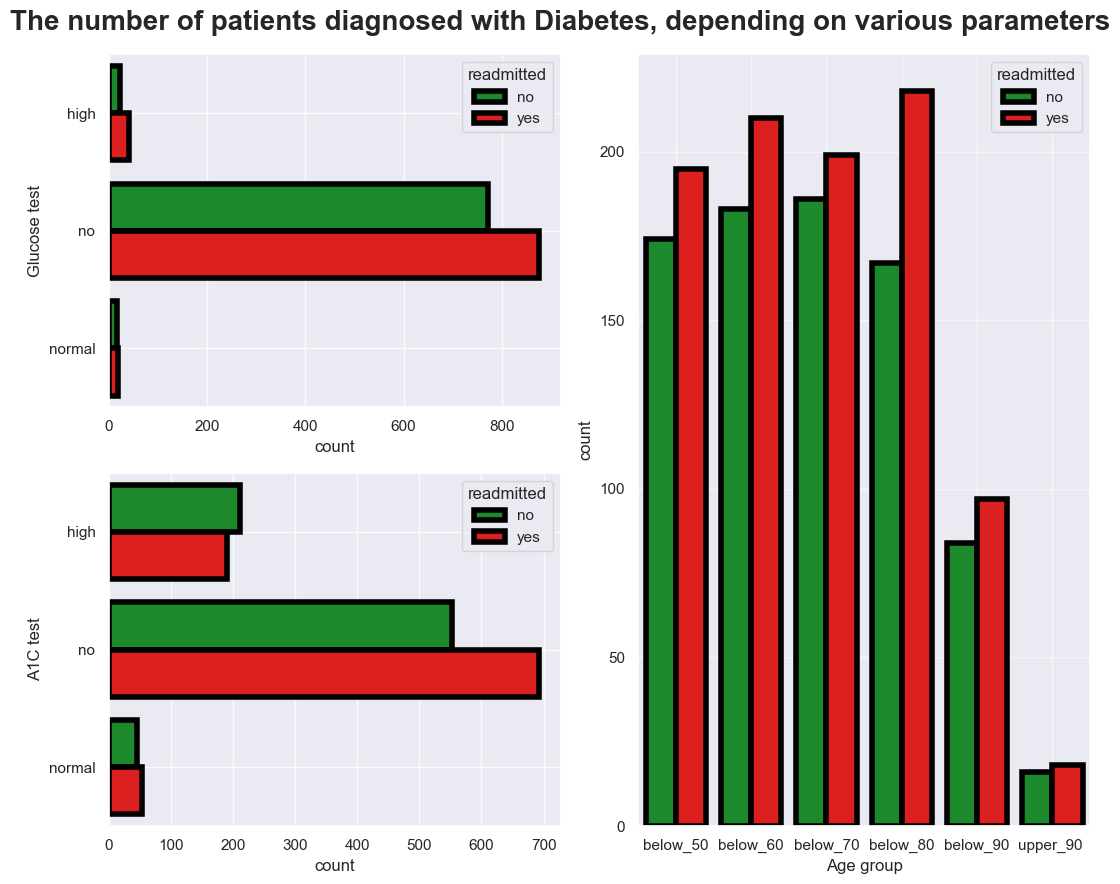

In [185]:
plt.figure(figsize=[11, 9])

plt.suptitle('The number of patients diagnosed with Diabetes, depending on various parameters', fontsize=20, fontweight='bold')

plt.subplot(2, 2, 1)
sns.barplot(data = glucose.query('diag_1 =="Diabetes"'),orient = 'h', y ='glucose_test',x = 'count' ,hue = 'readmitted',palette= ['#099b1f','#fb0100'],linewidth=4, edgecolor="black")

plt.ylabel('Glucose test')
plt.grid(alpha=0.8)


plt.subplot(2, 2, 3)
sns.barplot(data = a1ctest.query('diag_1 =="Diabetes"'),  y ='A1Ctest',x = 'count' ,hue = 'readmitted', palette= ['#099b1f','#fb0100'],linewidth=4, edgecolor="black")
plt.ylabel('A1C test')
plt.grid(alpha=0.8)

plt.subplot(1, 2, 2)
sns.barplot(data = age.query('diag_1 =="Diabetes"'),x ='age_cat',
            y = 'count',hue = 'readmitted', palette= ['#099b1f','#fb0100'],linewidth=4, edgecolor="black",);

plt.xlabel('Age group')
plt.grid(alpha=0.6)
plt.tight_layout()
plt.show()

We have received an excellent illustration that will fully answer the question about the impact of diabetes on the frequency of repeated hospitalizations. Those doctors who suggested that diabetes affects the frequency of repeated hospitalizations were RIGHT.
As you can see, for all age groups diagnosed with diabetes, the number of re-hospitalizations is greater than for the primary one, and this is taking into account that our total number of re-hospitalizations was less.
Also, the presence of glucose tests and A1C tests done or not confirm our assumptions.



Hospitalization is an opportunity for doctors to influence the change in the direction of treatment of patients. The resources available in an inpatient setting are often much larger than the resources available to an outpatient practitioner, and they can be used to provide care. The average hospital stay in the current data set was 4.45 days, which would allow to study the treatment of diabetes and develop a plan that would be most effective if justified.

#### We can relax, exhale and move on to the third question of our research work.

## 3. On what groups of patients should the hospital focus their follow-up efforts to better monitor patients with a high probability of readmission?

In [186]:
df = pd.read_csv('data/hospital_readmissions.csv')

In [187]:
df['visit'] = df.n_outpatient + df.n_inpatient + df.n_emergency

df.loc[(df['visit']>=1)&(df['visit']<4),'visit']=1
df.loc[(df['visit']>=4)&(df['visit']<8),'visit']=2
df.loc[(df['visit']>=8)&(df['visit']<11),'visit']=3

df.loc[(df['visit']>=11),'visit']=4

In [188]:
#df['visit'] = df.n_outpatient + df.n_inpatient + df.n_emergency
#df.loc[df['visit']>0,'visit']=1

df.loc[df['age'] ==  '[40-50)', ['age']] = 1
df.loc[df['age'] == '[50-60)', ['age']] = 2
df.loc[df['age'] ==  '[60-70)', ['age']] = 3
df.loc[df['age'] == '[70-80)', ['age']] = 3
df.loc[df['age'] == '[80-90)', ['age']] = 3
df.loc[df['age'] == '[90-100)', ['age']] = 4

In [189]:
df['n_procedur'] = df.n_lab_procedures + df.n_procedures

df.loc[(df['n_procedur']>=1)&(df['n_procedur']<20),'n_procedur']=1
df.loc[(df['n_procedur']>=20)&(df['n_procedur']<40),'n_procedur']=2
df.loc[(df['n_procedur']>=40)&(df['n_procedur']<60),'n_procedur']=3
df.loc[(df['n_procedur']>=60)&(df['n_procedur']<80),'n_procedur']=4

df.loc[(df['n_procedur']>=80),'n_procedur']=5
df = df.drop(columns = ['n_outpatient','n_inpatient','n_emergency','n_lab_procedures' , 'n_procedures'])

In [190]:
X = pd.get_dummies(df, columns=['diag_1', 'diag_2', 'diag_3','glucose_test', 'medical_specialty', 'A1Ctest','change','diabetes_med'], drop_first = True)
y = LabelEncoder().fit_transform(X[ 'readmitted'])
X = X.drop('readmitted', axis=1)

In [191]:
   
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=69)
X_test,X_val,y_test,y_val = train_test_split(X_test, y_test, test_size=0.1, random_state=69)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

## Random Forest

In [192]:
def plot_confusion_matrix( cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          ):
    
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('summer')

    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)



    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="black" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [193]:
def plotly_roc_curves_and_heatmap (x,y, model, X_train,X_test, X_val,y_train,
                                   y_test,y_val,model_title):
    plt.figure(figsize=[x, y])
    plt.suptitle('Roc curves for a'+ model_title + 'based on test data and validation data', fontsize=20, fontweight='bold')
    
    plt.subplot(2, 2, 1)
    model.fit(X_train, y_train)
    model_probs = model.predict_proba(X_test)
    model_probs = model_probs[:, 1]
    fpr1, tpr1, treshold = roc_curve(y_test, model_probs)
    roc_auc1 = auc(fpr1, tpr1)
    plt.plot(fpr1, tpr1,color='darkorange',
         label='ROC curves (area = %0.2f)' % roc_auc1)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Roc curves on test data')

    plt.legend(loc="lower right")
    plt.grid(alpha=0.8)


    plt.subplot(2, 2, 3)
    model_probs_v = model.predict_proba(X_val)
    model_probs_v = model_probs_v[:, 1]
    fpr2, tpr2, treshold = roc_curve(y_val, model_probs_v)
    roc_auc2 = auc(fpr2, tpr2)
    plt.plot(fpr2, tpr2,color='darkorange',
         label='ROC curves (area = %0.2f)' % roc_auc2)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Roc curves  on validation data')

    plt.legend(loc="lower right")
    plt.grid(alpha=0.8)


    plt.subplot(2, 2, 2)
    cm = confusion_matrix(y_test, model.predict(X_test))
    group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]

    labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.title('Confusion matrix  on test data')
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.8)
    
    plt.subplot(2, 2, 4)
    cm = confusion_matrix(y_val,rf.predict(X_val))
    group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm, annot=labels, fmt='', cmap='summer_r')
    plt.title('Confusion matrix on validation data')

    plt.legend(loc="lower right")
    plt.grid(alpha=0.8)
plt.show()

In [194]:
rf = RandomForestClassifier(max_depth = 5, max_features=3, min_samples_leaf=1, min_samples_split=3, n_estimators=35)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(f'Random Forest Test score {rf.score(X_test, y_test).round(2)}')

Random Forest Test score 0.58


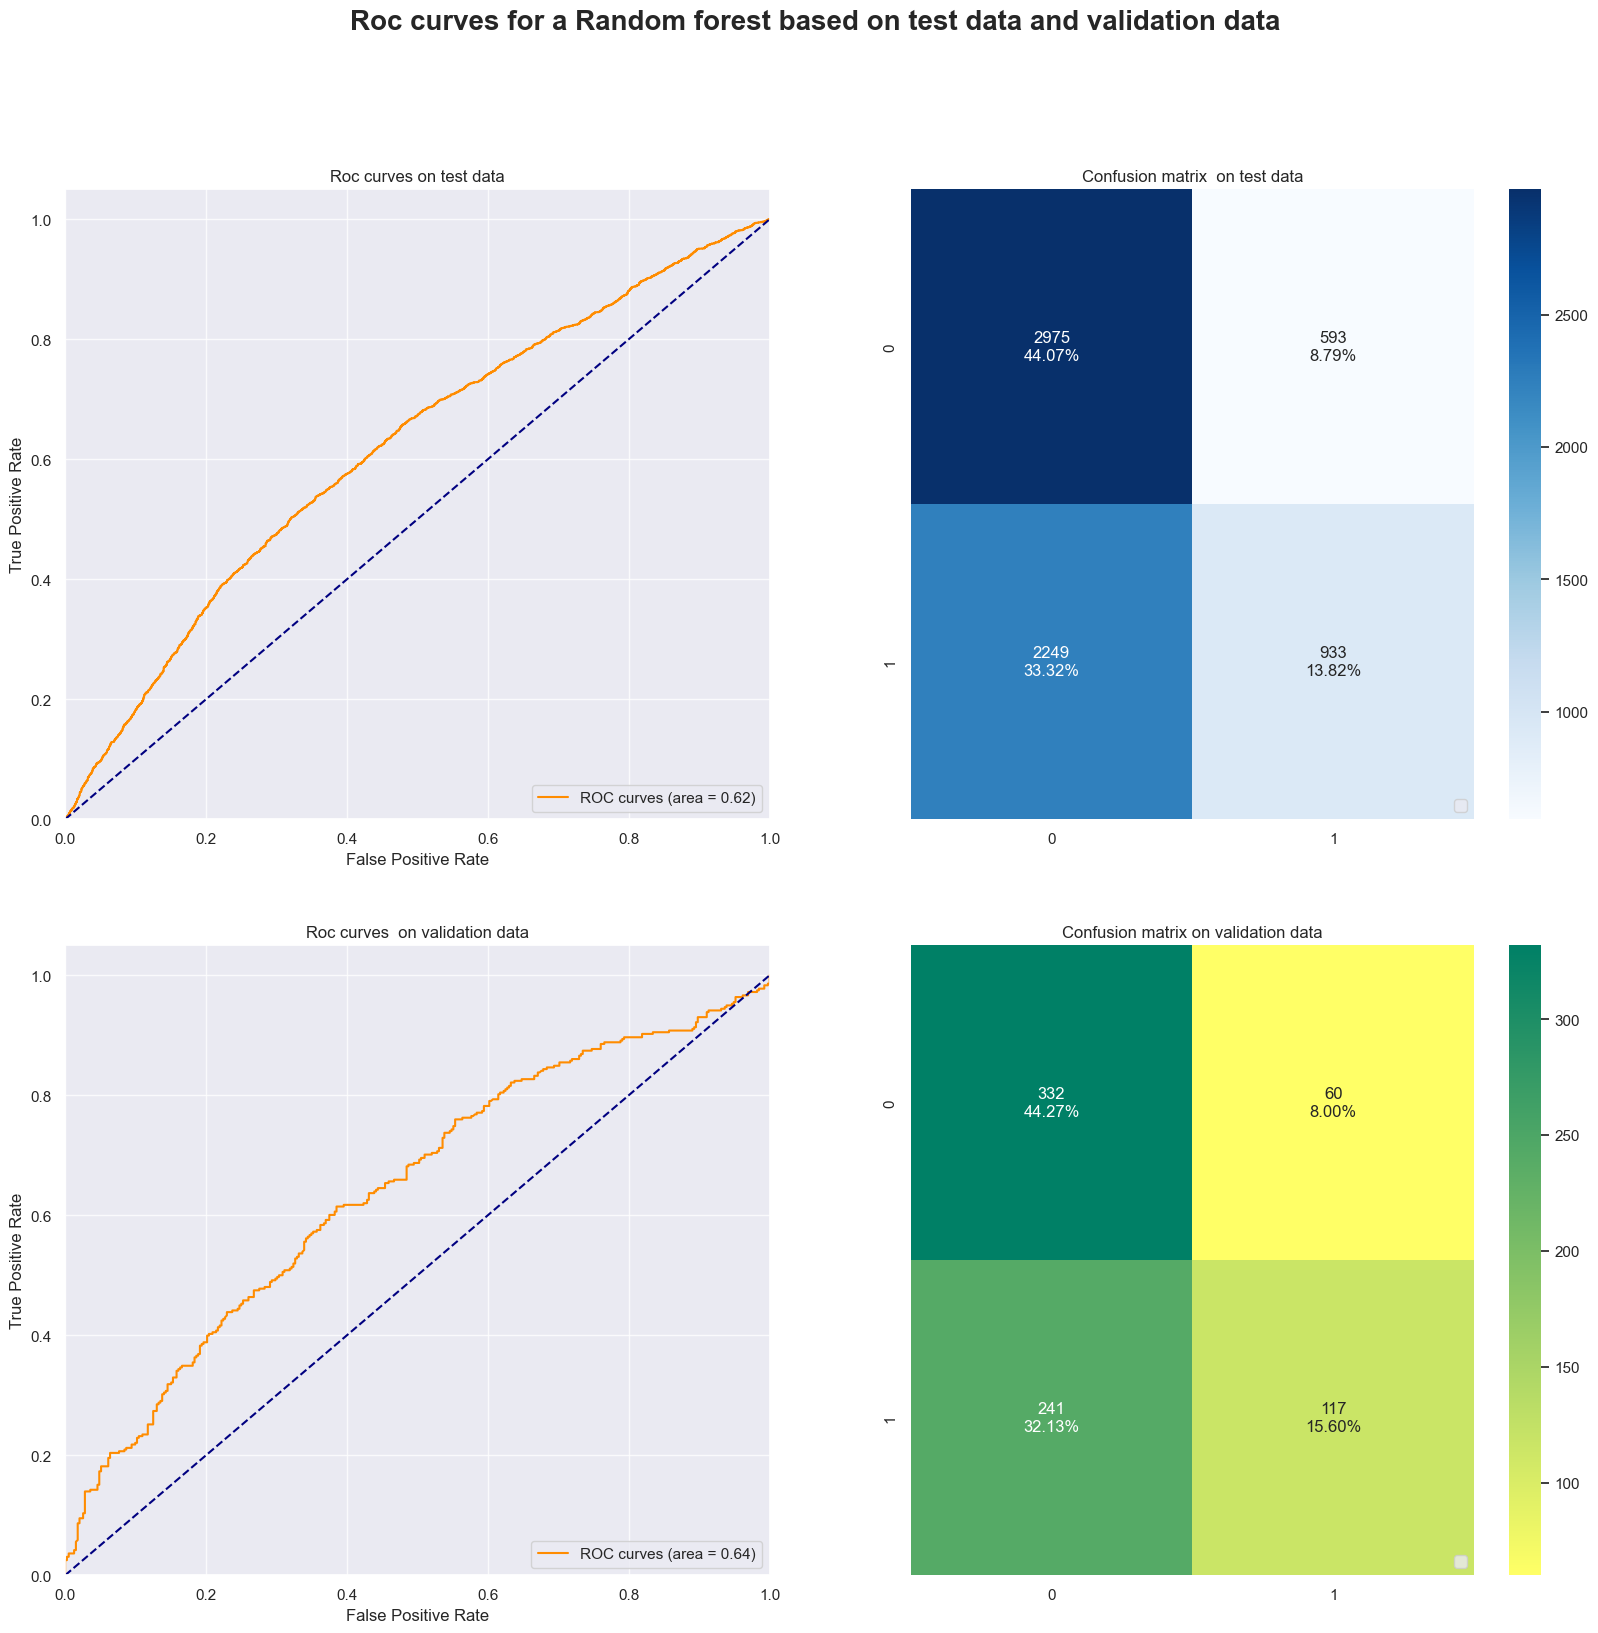

In [195]:
plotly_roc_curves_and_heatmap(20,18, rf, X_train,X_test, X_val,
                              y_train, y_test,y_val,' Random forest ')


## SGD Classifier

In [196]:
SGD = SGDClassifier(alpha=0.05, fit_intercept=True, loss='log', n_iter_no_change=500,
penalty='l2')
SGD.fit(X_train, y_train)
print(f'Linear regression SGD Test score {SGD.score(X_test, y_test).round(2)}')

Linear regression SGD Test score 0.61


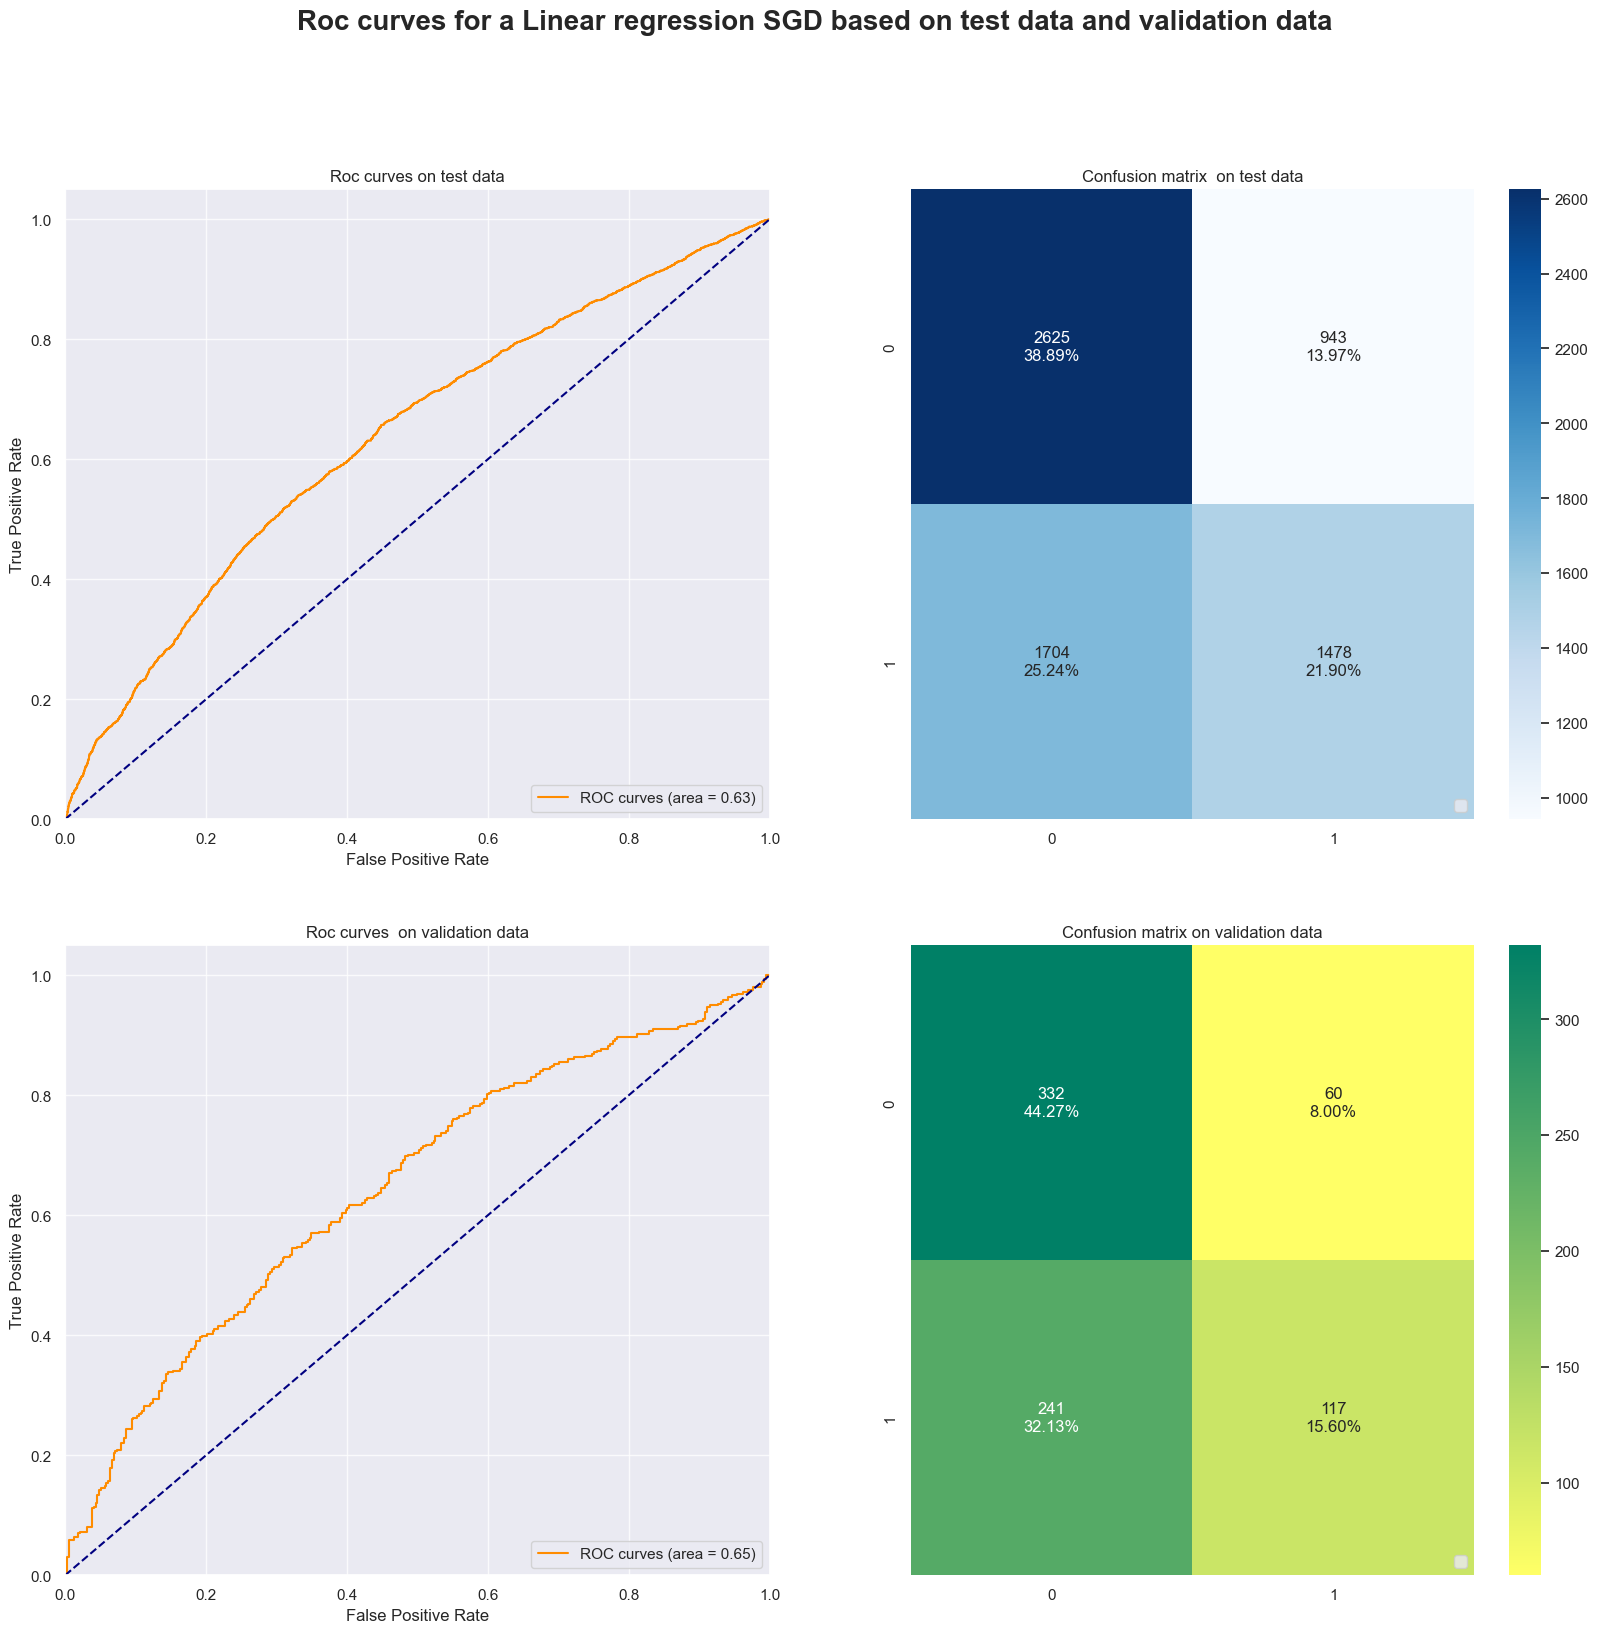

In [197]:
plotly_roc_curves_and_heatmap(20,18, SGD, X_train,X_test, X_val,
                              y_train, y_test,y_val,' Linear regression SGD ')

## XGBoost

In [198]:
xg = xgb.XGBClassifier(colsample_bytree= 0.3, gamma= 0.1, learning_rate= 0.1, max_depth= 5,min_child_weight= 3)
xg.fit(np.array(X_train),y_train)
print(f'XGBoost Test score {xg.score(X_test, y_test).round(2)}')


XGBoost Test score 0.61


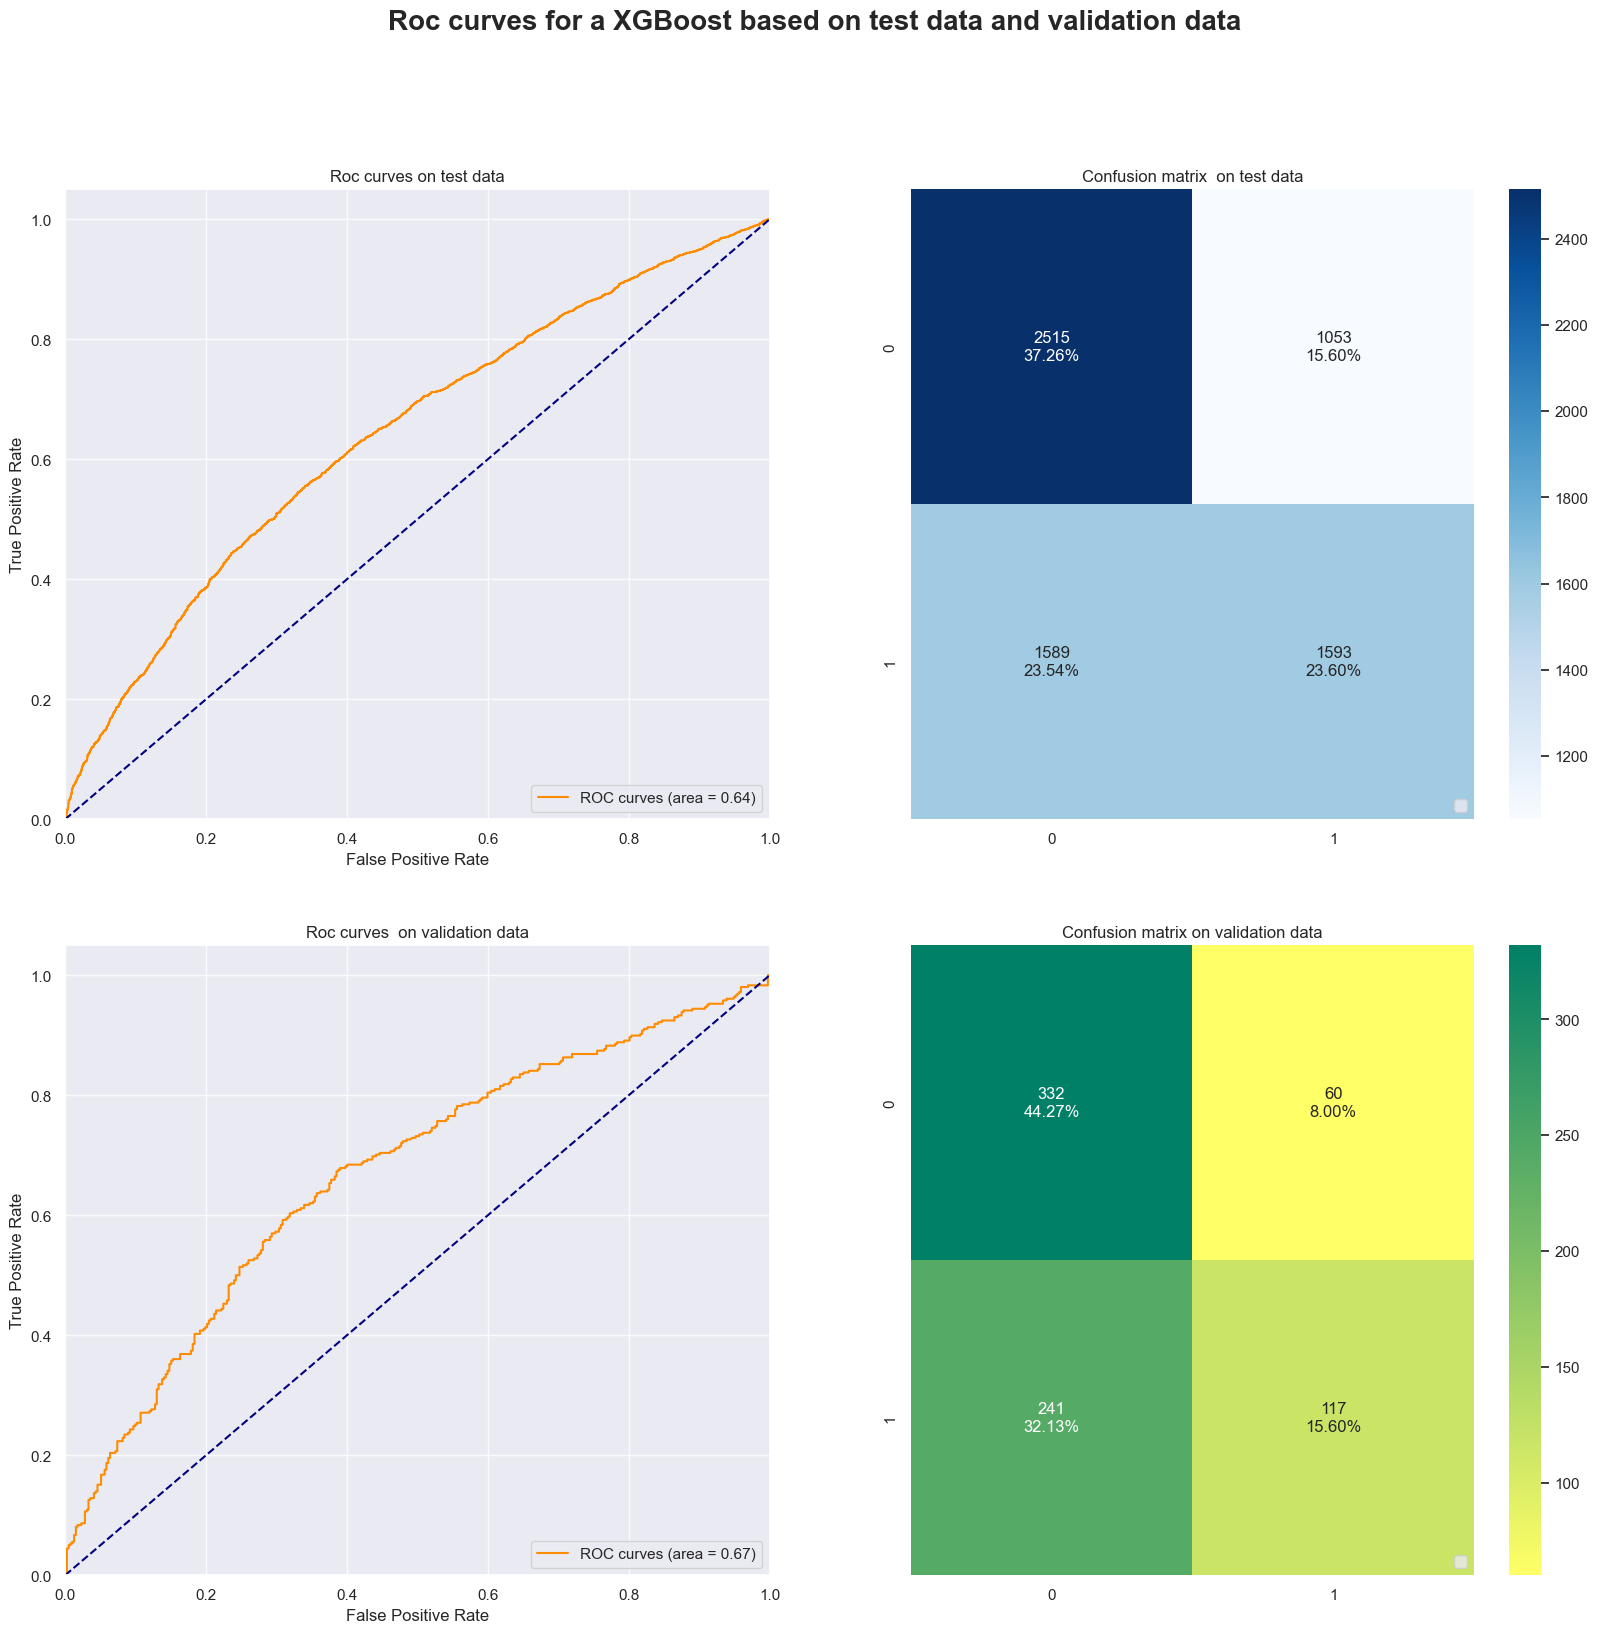

In [199]:
plotly_roc_curves_and_heatmap(20,18, xg, X_train,X_test, X_val,
                              y_train, y_test,y_val,' XGBoost ')

## Deep Neural network

In [200]:
def auc(y_true, y_pred):
  auc = tf.py_function(metrics.roc_auc_score, (y_true, y_pred), tf.double)
  return auc

from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [201]:
y_train = tf.keras.utils.to_categorical(y_train, 2)
y_test = tf.keras.utils.to_categorical(y_test, 2)
y_val = tf.keras.utils.to_categorical(y_val, 2)

In [202]:
tf.keras.backend.clear_session()
model = tf.keras.models.Sequential()
input_layer = tf.keras.Input(shape=(38,))#39

layer1 = tf.keras.layers.Dense(250,activation='relu')(input_layer)
layer2 = tf.keras.layers.Dense(120,activation='relu')(layer1)
layer3 = tf.keras.layers.Dense(60,activation='softmax')(layer2)#
layer4 = tf.keras.layers.Dense(30,activation='relu')(layer3)
layer5 = tf.keras.layers.Dense(15,activation='softmax')(layer4)#

output = tf.keras.layers.Dense(2,activation='softmax',kernel_initializer=tf.initializers.he_uniform())(layer5)

model = tf.keras.Model(inputs=input_layer,outputs=output)

optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,name='Adam')

es = EarlyStopping(monitor='val_loss', mode='min',verbose=1,patience=2,restore_best_weights=True)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='./graph002',histogram_freq=1, write_graph=True,write_grads=True)


scheduler = ReduceLROnPlateau(monitor='val_auc', factor=0.9, patience=0, verbose=1,mode = 'max')

model.compile(optimizer=optimizer, loss='categorical_crossentropy',metrics =[auc,f1])

callback_list = [tensorboard_callback,scheduler,es]



In [203]:
#X_train = np.array(X_train).astype(np.int)
#X_test = np.array(X_test).astype(np.int)
#y_train = np.array(y_train).astype(np.int)
#y_test = np.array(y_test).astype(np.int)
#X_val = np.array(X_test).astype(np.int)
#y_val = np.array(y_train).astype(np.int)


In [204]:
model.fit(X_train,y_train,epochs=150, validation_data=(X_test,y_test), batch_size=100, callbacks=callback_list)

Epoch 1/150
175/175 [==============================] - 1s 5ms/step - loss: 0.6913 - auc: 0.5845 - f1: 0.5306 - val_loss: 0.6914 - val_auc: 0.5983 - val_f1: 0.5290 - lr: 1.0000e-04
Epoch 2/150
175/175 [==============================] - 1s 4ms/step - loss: 0.6905 - auc: 0.6259 - f1: 0.5306 - val_loss: 0.6896 - val_auc: 0.6093 - val_f1: 0.5290 - lr: 1.0000e-04
Epoch 3/150
175/175 [==============================] - 1s 4ms/step - loss: 0.6861 - auc: 0.6398 - f1: 0.5306 - val_loss: 0.6841 - val_auc: 0.6314 - val_f1: 0.5290 - lr: 1.0000e-04
Epoch 4/150
175/175 [==============================] - 1s 4ms/step - loss: 0.6803 - auc: 0.6469 - f1: 0.5734 - val_loss: 0.6791 - val_auc: 0.6345 - val_f1: 0.6044 - lr: 1.0000e-04
Epoch 5/150
175/175 [==============================] - 1s 4ms/step - loss: 0.6750 - auc: 0.6529 - f1: 0.6145 - val_loss: 0.6750 - val_auc: 0.6357 - val_f1: 0.6051 - lr: 1.0000e-04
Epoch 6/150
173/175 [============================>.] - ETA: 0s - loss: 0.6700 - auc: 0.6542 - f1: 0.

In [205]:
fc_auc = model.predict(X_test)
y_pred = np.argmax(fc_auc,axis=1)
y_true = np.argmax(y_test,axis=1)
print("Test AUC:",auc(y_test,fc_auc))
print("Test f1:",f1(y_test,fc_auc))


211/211 [==============================] - 0s 704us/step
Test AUC: tf.Tensor(0.6349483184561138, shape=(), dtype=float64)
Test f1: tf.Tensor(0.60651845, shape=(), dtype=float32)


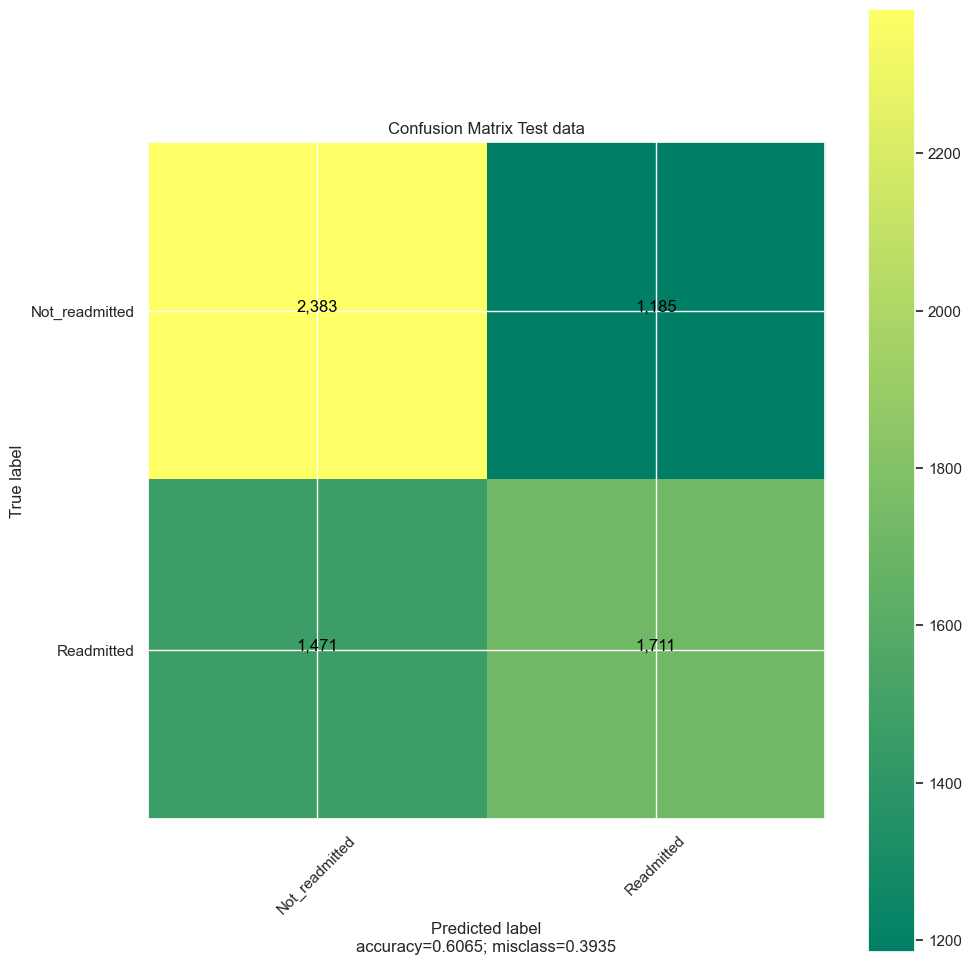

In [206]:
plot_confusion_matrix(cm = confusion_matrix(y_true,y_pred),target_names = ['Not_readmitted', 'Readmitted'],title= "Confusion Matrix Test data")

24/24 [==============================] - 0s 680us/step


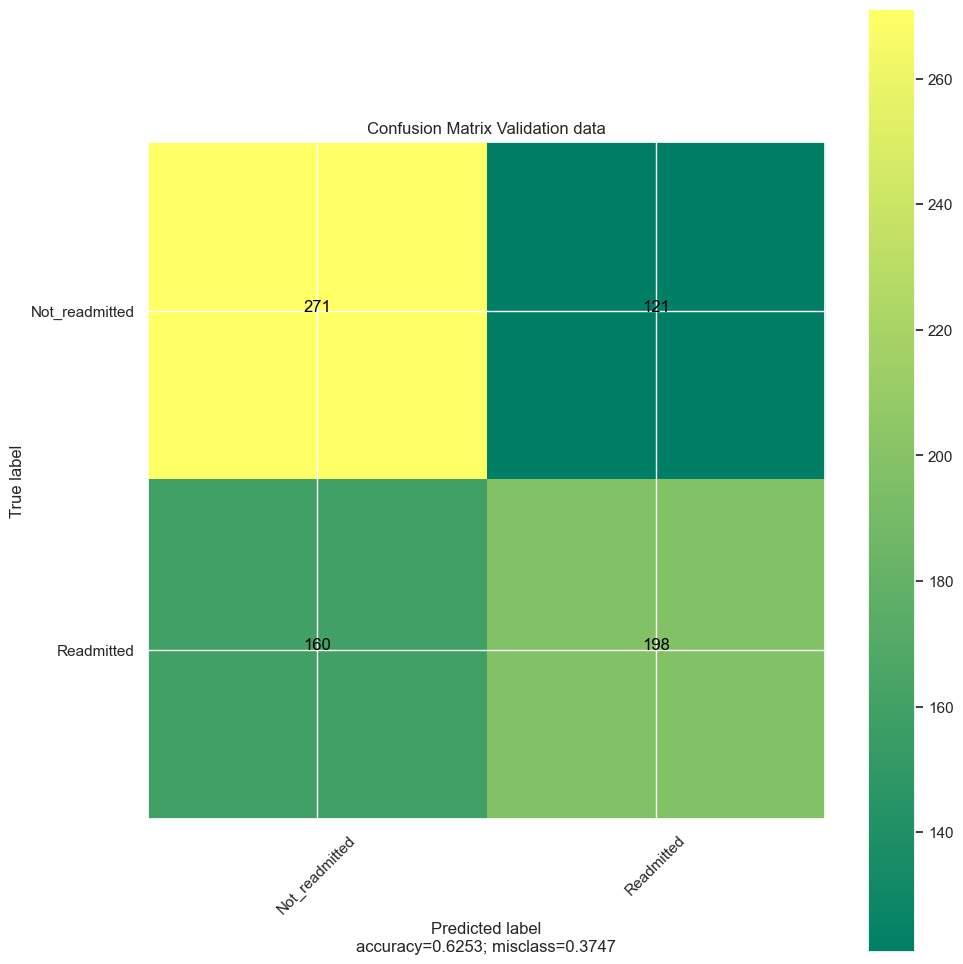

In [207]:
fc_auc = model.predict(X_val)
y_pred = np.argmax(fc_auc,axis=1)
y_true = np.argmax(y_val,axis=1)
plot_confusion_matrix(cm = confusion_matrix(y_true,y_pred),target_names = ['Not_readmitted', 'Readmitted'],title= "Confusion Matrix Validation data")

In [208]:
results = model.evaluate(X_test, y_test, batch_size=30)
loss = round(results[0],2)
auc = round(results[1],2)
f1 = round(results[2],2)

225/225 [==============================] - 0s 2ms/step - loss: 0.6659 - auc: 0.6349 - f1: 0.6065


In [209]:
results = model.evaluate(X_val, y_val, batch_size=25)
loss = round(results[0],3)
auc = round(results[1],3)
f1 = round(results[2],3)

30/30 [==============================] - 0s 2ms/step - loss: 0.6590 - auc: 0.6641 - f1: 0.6253


In [210]:
print(f'Deep Neural network: \nLoss_function = {loss},\nAuc = {auc}, \nF1_score = {f1}  ')



Deep Neural network: 
Loss_function = 0.659,
Auc = 0.664, 
F1_score = 0.625  


To answer the third question, I wanted to involve machine learning and try to predict readmission for patients, but after many efforts to study machine learning and deep learning models, I did not get the desired result. I was deeply disappointed with the accuracy of the models and tried to adjust them to increased efficiency, but unfortunately the most that I managed to "survive" from my knowledge and data is the accuracy of predictions equal to 0.67. As I have already said, at first I was upset by the rather low estimate of predictions, but as I immersed myself in the data, I became fully aware that our data set had reached not only pre-processed, but also sufficiently reduced. Because there is no division into the gender of the patient in them , this is a very important characteristic since men and women carry the same diseases differently . The next characteristics that we don't see are the test results, because there are patients who have had more than a hundred procedures, all these functions should give additional predictive scores for our models.
### Therefore, we will leave further model development and try to answer the third question by analyzing our data.

Probably in order to answer our question correctly, we need to find out what all hospitalized people have in common. and see what the other patients have in common.


In [211]:
df = pd.read_csv('data/hospital_readmissions.csv')


In [212]:
df = df[df['diag_1'] != "Missing"]
df.insert(0, 'age_cat', df.age)
char_to_replace = {'[70-80)': 'below_80',
                   '[60-70)': 'below_70',
                   '[80-90)': 'below_90',
                   '[50-60)': 'below_60',
                   '[40-50)': 'below_50',
                   '[90-100)': 'upper_90'}
for key, value in char_to_replace.items():
    df.age_cat = df.age_cat.replace(key, value)

In [213]:
df['n_procedur'] = df.n_lab_procedures + df.n_procedures

df.loc[(df['n_procedur']>=1)&(df['n_procedur']<20),'n_procedur']=1
df.loc[(df['n_procedur']>=20)&(df['n_procedur']<40),'n_procedur']=2
df.loc[(df['n_procedur']>=40)&(df['n_procedur']<60),'n_procedur']=3
df.loc[(df['n_procedur']>=60)&(df['n_procedur']<80),'n_procedur']=4

df.loc[(df['n_procedur']>=80),'n_procedur']=5

In [214]:
df['visit'] = df.n_outpatient + df.n_inpatient + df.n_emergency

df.loc[(df['visit']>=1)&(df['visit']<4),'visit']=1
df.loc[(df['visit']>=4)&(df['visit']<8),'visit']=2
df.loc[(df['visit']>=8)&(df['visit']<11),'visit']=3

df.loc[(df['visit']>=11),'visit']=4



In [215]:
df = df.drop(columns = ['age','n_outpatient','n_inpatient','n_emergency','n_lab_procedures' , 'n_procedures'])#

In [216]:
df50 = df[df['age_cat'] =="below_50"]
df60 = df[df['age_cat'] =="below_60"]
df70 = df[df['age_cat'] =="below_70"]
df80 = df[df['age_cat'] =="below_80"]
df90 = df[df['age_cat'] =="below_90"]
df100 = df[df['age_cat'] =="upper_90"]

### Let's sort out our patients by age and try to give recommendations for each group. Although we will get a large number of similar graphs, but we will understand what feature each age group may have.

In [217]:
def bar(title,xlabel,ylabel,DataFrame,x,color,xsize=None,ysize=None, lim1 = None,lim2= None,xlim1 = None):
    df = DataFrame.groupby([x, color,]).count().reset_index()[[x,color,'age_cat']]\
        .rename(columns = {'age_cat':'count'})

    if lim1 or lim2 is  not None:
       df = df[(df[x]<=lim2)&(df[x]>lim1)]
    
    if xsize or ysize is  not None:
        plt.figure(figsize=(xsize, ysize))
    plt.xticks(rotation=35, fontsize=10);

    ax = sns.barplot(data = df , x = x, y = 'count',edgecolor='black',linewidth=2,hue = color)
    ax.set_xlim([xlim1, lim2])

    plt.title(title,fontsize=10)
    plt.xlabel(xlabel,fontsize = 8)
    plt.ylabel(ylabel,fontsize = 8)

    patch_h = [patch.get_height() for patch in ax.patches]
    y1,y2 = patch_h[0:len(df[x])//2], patch_h[len(df[x])//2:]
    
    for i in range(len(df[x])//2):
        if y2[i]>=y1[i]:
            ax.patches[i+len(df[x])//2].set_facecolor('red') 
            
        elif y1[i]-y2[i]<=round(0.1*y1[i],0):
            ax.patches[i+len(df[x])//2].set_facecolor('yellow')
            
        elif y1[i]-y2[i]>round(0.1*y1[i],0) and y1[i]-y2[i]<=round(0.20*y1[i],0):
            ax.patches[i+len(df[x])//2].set_facecolor('green') 

    for i in ax.patches:
        plt.annotate(format(i.get_height(),".0f"), xy=(i.get_x() + i.get_width() / 2,
                                          i.get_height()),ha='center',va='bottom',rotation=0,fontsize = 9)
    
    plt.show()   

In [218]:
def plot(age1,age2,df,xlim1,xlim2):
    bar("The number of patients aged "+age1+" to "+ age2+" years, depending on the diagnosis.\n\
        yellow - 10 % threshold ,green - 10-20 % threshold ,red - exceeding"\
    ,"Diagnosis","Number of patients",df,"diag_1",'readmitted',12,3)

    bar("The number of patients aged "+age1+" to "+ age2+" years, depending on the number of visits.\n\
        yellow - 10 % threshold ,green - 10-20 % threshold ,red - exceeding"\
    ,"Number of visits","Number of patients",df,"visit",'readmitted',12,3)

    bar("The number of patients aged "+age1+" to "+ age2+" years, depending on the number of procedures.\n\
        yellow - 10 % threshold ,green - 10-20 % threshold ,red - exceeding"\
    ,"Number of procedures","Number of patients",df,"n_procedur",'readmitted',12,3)

    bar("The number of patients aged "+age1+" to "+ age2+" years, depending on the time spent in the hospital.\n\
        yellow - 10 % threshold ,green - 10-20 % threshold ,red - exceeding"\
    ,"Time spent in the hospital","Number of patients",df,"time_in_hospital",'readmitted',12,3)

    bar("The number of patients aged "+age1+" to "+ age2+" years, depending on the glucose serum .\n\
        yellow - 10 % threshold ,green - 10-20 % threshold ,red - exceeding"\
    ,"The glucose serum ","Number of patients",df,"glucose_test",'readmitted',12,3)

    bar("The number of patients aged "+age1+" to "+ age2+" years, depending on  the specialty of the admitting physician.\n\
        yellow - 10 % threshold ,green - 10-20 % threshold ,red - exceeding"\
    ," The specialty of the admitting physician","Number of patients",df,"medical_specialty",'readmitted',12,3)


    bar("The number of patients aged "+age1+" to "+ age2+" years, depending on the number of medications administered.\n\
        yellow - 10 % threshold ,green - 10-20 % threshold ,red - exceeding"\
    ,"Number of medications administered","Number of patients",df,"n_medications",'readmitted',15,9,xlim1,xlim2)


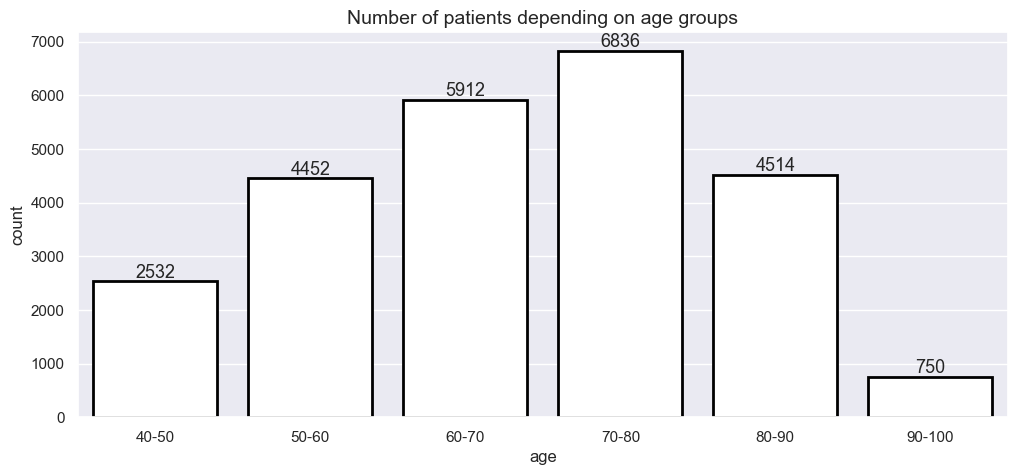

In [219]:
len_group = {'40-50':len(df50),
            '50-60':len(df60),
            '60-70':len(df70),
            '70-80':len(df80),
            '80-90':len(df90),
            '90-100':len(df100)}
len_group = pd.DataFrame(len_group.items(),columns = ['age','count'])

plt.figure(figsize=(12, 5))
plt.title('Number of patients depending on age groups',fontsize=14)

ax = sns.barplot(data = len_group, x = 'age', y ='count', color ='white',edgecolor='black',linewidth=2)

patch_h = [patch.get_height() for patch in ax.patches]

for i in ax.patches:
    plt.annotate(format(i.get_height(),".0f"), xy=(i.get_x() + i.get_width() / 2,
                                          i.get_height()),ha='center',va='bottom',rotation=0,fontsize = 13)

### Age group 40-50 years

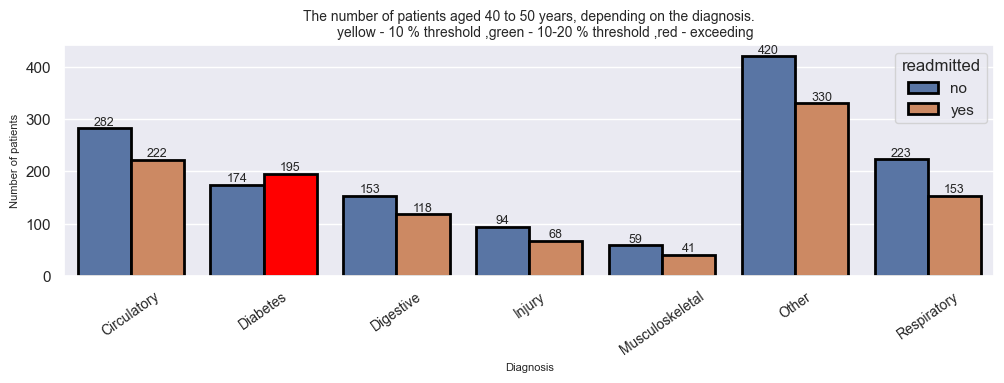

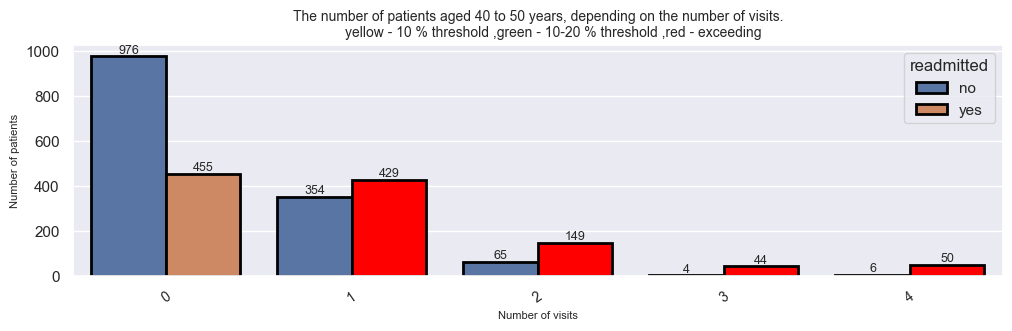

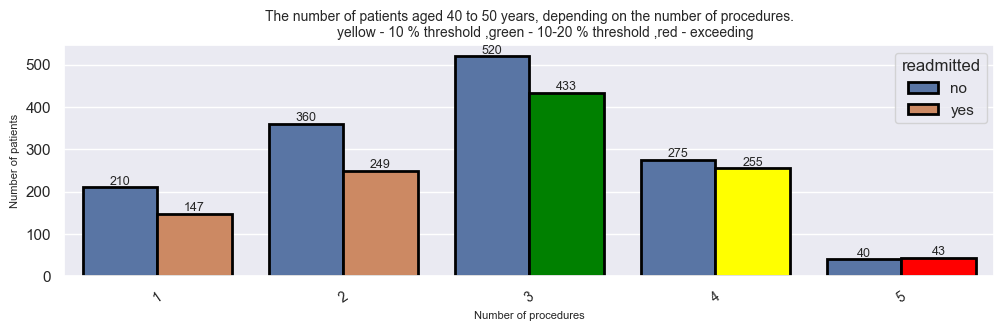

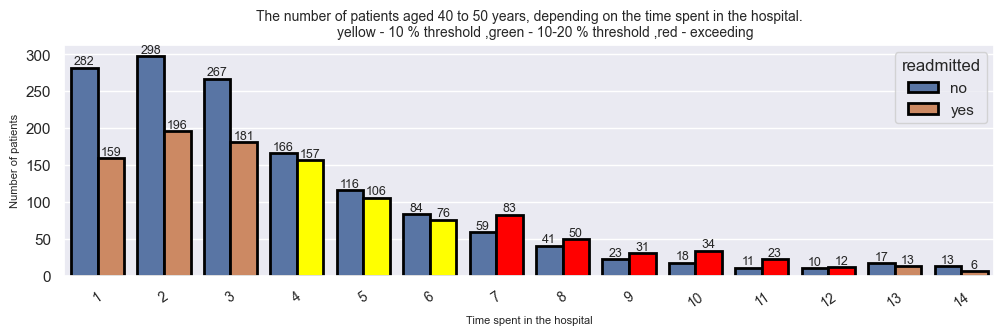

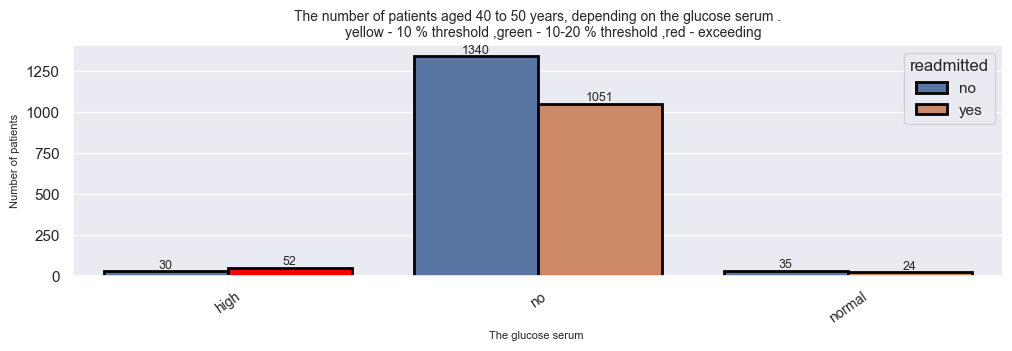

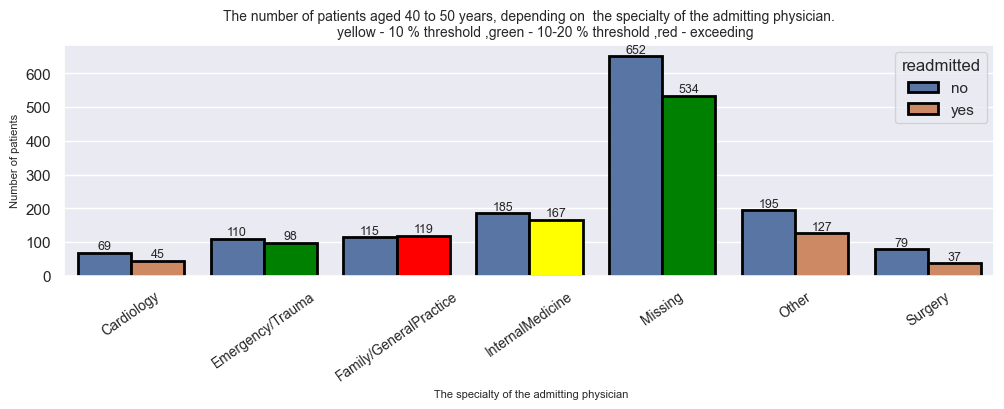

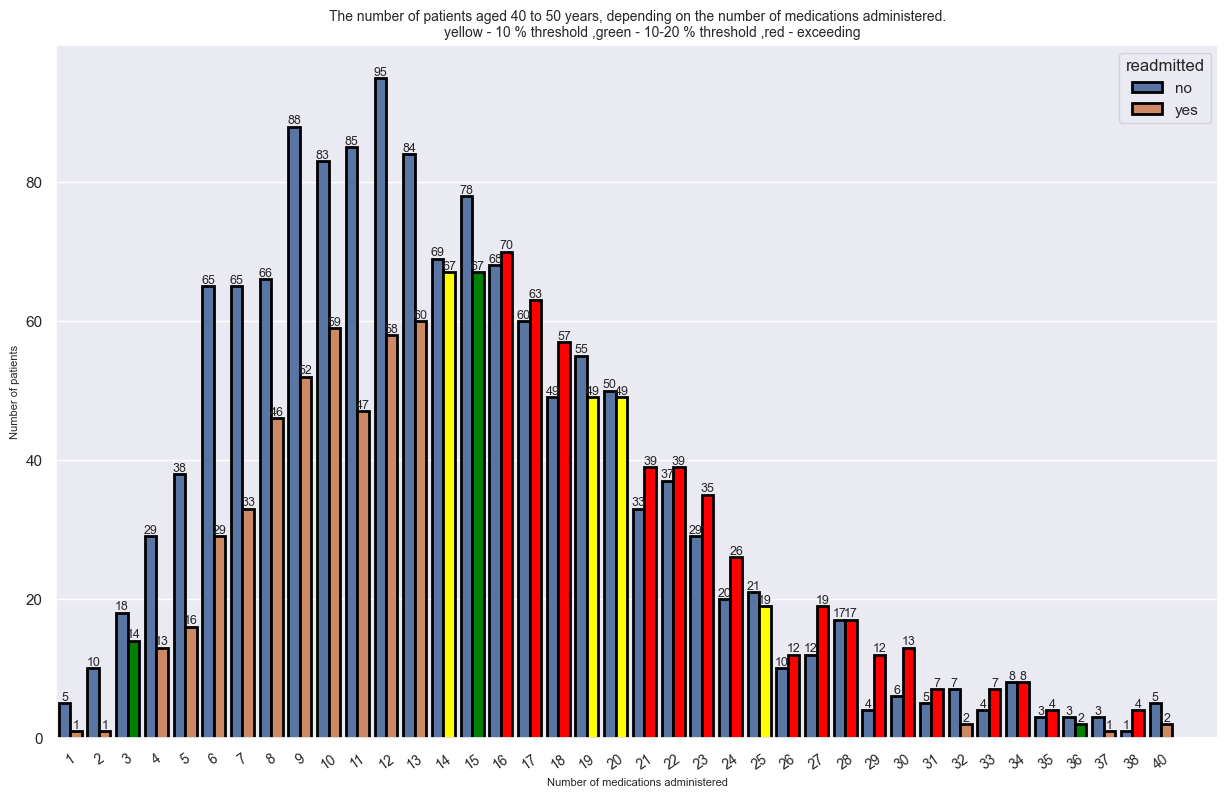

In [220]:
plot('40','50',df50,-.5,40)


For the age group of 40-50 years, there is an increased re-hospitalization with a diagnosis of Diabetes. For the rest of the diagnoses, the gap in hospitalization does not exceed the 30% threshold introduced by us to control those groups where it is worth paying special attention to patients. The dependence of repeated hospitalization on the number of hospital visits over the past year is very well traced. Only a third of the patients who had no hospital visits in the previous year were subject to readmission. Having at least 1 visit changes the picture dramatically. The most common group is 1-3 visits, in which about 55% of patients had repeated hospitalization, the clinical picture is worse and almost 70% of patients are admitted to the hospital again.
With the number of procedures performed, the picture is as follows: the most common is the third group (40-60 procedures), the number of re-hospitalization is already beginning to increase from it, and as we see (the barplot is marked in green), the 30% threshold has been exceeded (the difference is less than 30% between patients with and without re-hospitalization) and then it increases, in the last group the number of re-hospitalized exceeds the rest.

Basically, the time spent in the hospital is no more than three days, it is up to 3 days that the highest number of patients and the lowest percentage of repeated hospitalizations. From 4 to 6 days, this percentage differs by no more than 10% from the number of ordinary patients. From the 7th day and almost to the end of the two-week stay in the hospital, the number of repeated hospitalizations is higher. As you have seen before, in most cases the "glucose_test" was not carried out in the hospital, we do not know the specifics of this decision, but what we see is that with a high test, the number of patients re-hospitalized is higher than usual. General practitioners have a higher percentage of re-hospitalized patients.
It is also seen that the percentage of repeated hospitalizations increases with a large number of prescribed medications in the hospital, starting from 16 units and further drugs, we see that the percentage of repeated hospitalizations increases.

### We have described the youngest age subgroup let's write down recommendations for it:
 - Pay attention to the disease Diabetes;
 - Pay attention to patients who have applied for various help in the previous year. The chance of their re-hospitalization increases;
 - Pay attention to those patients who have spent more than 1 week in the hospital;

 Well, as a rule, these are still quite young patients with fairly good health, and if you try to instill in them a culture to monitor their health "here and now", it is possible that when they move to the next age group, the percentage of re-hospitalization among them will be lower.


### Age group 50-60 years


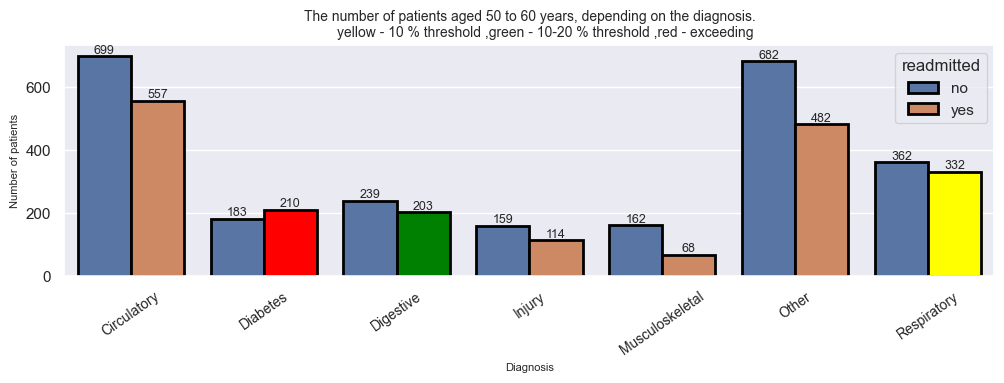

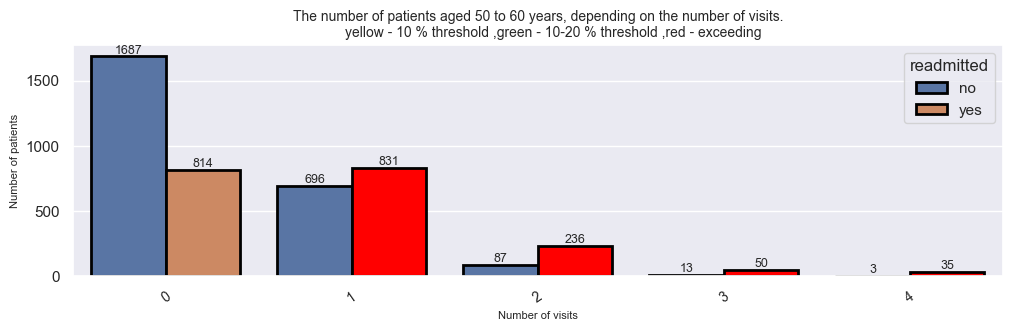

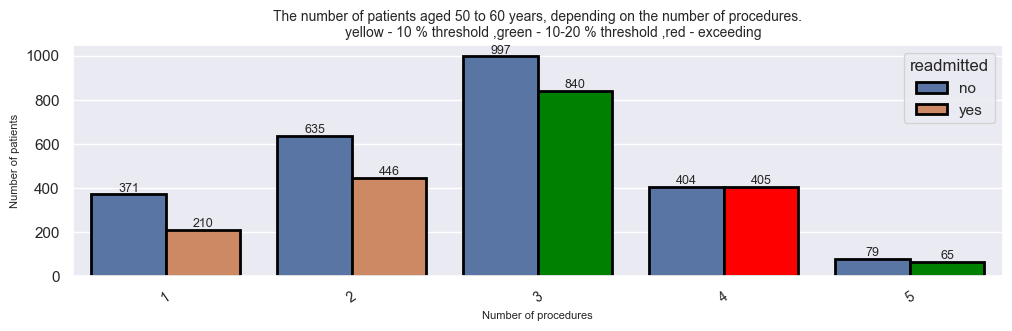

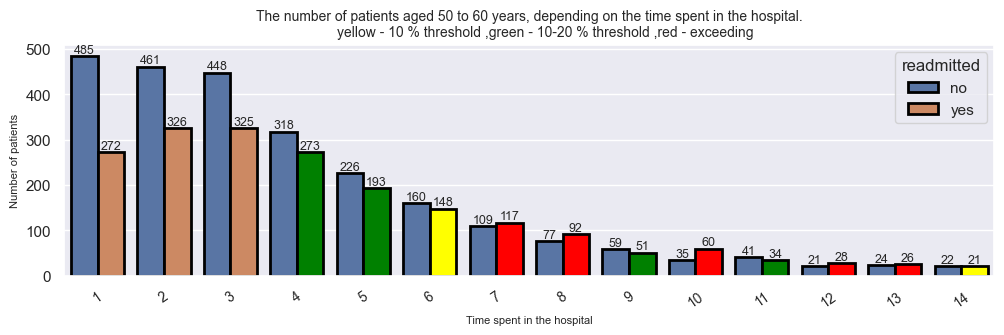

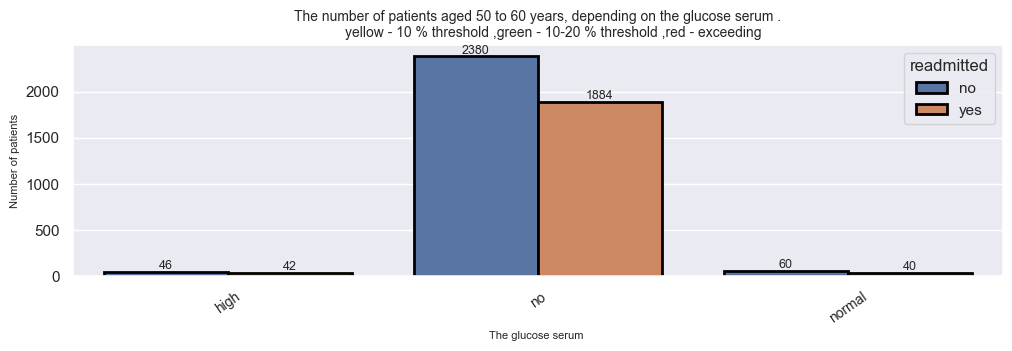

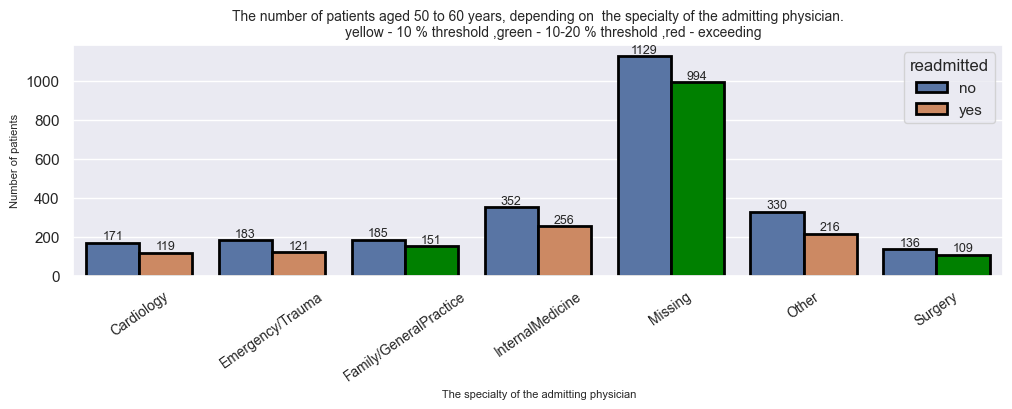

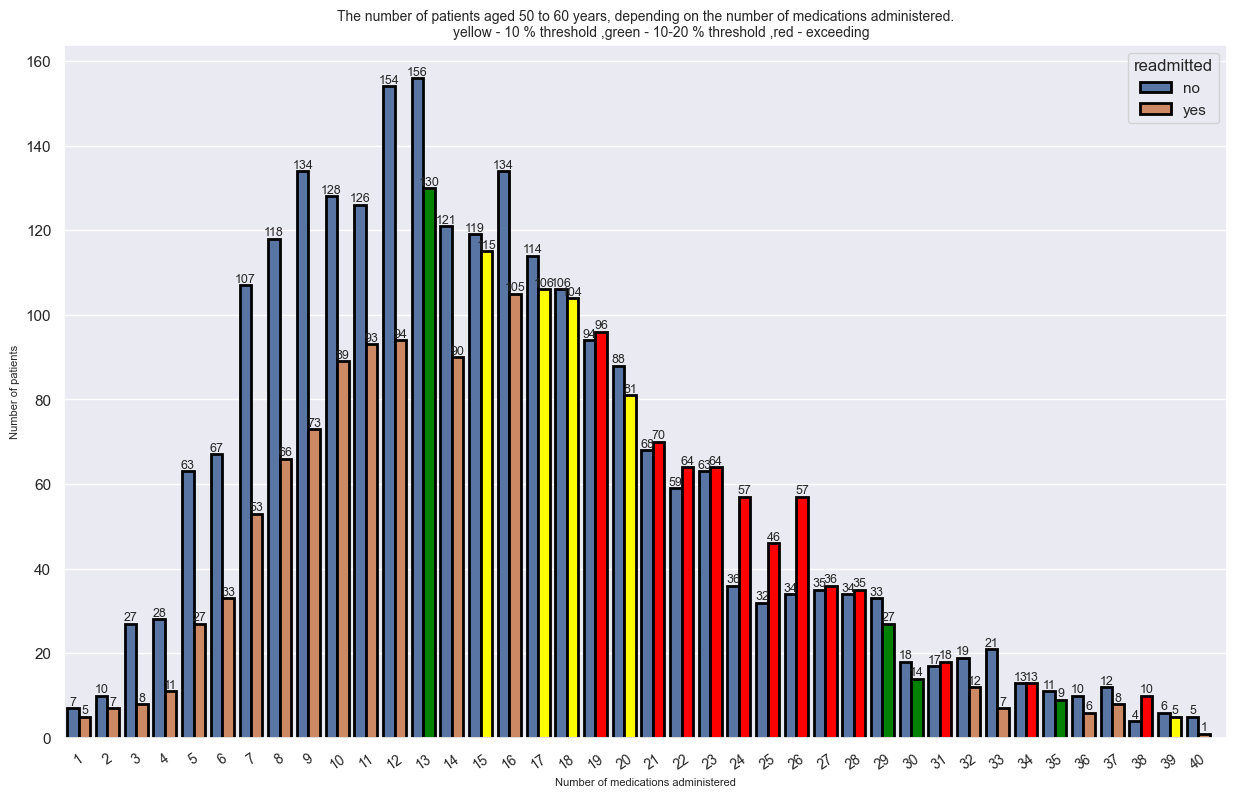

In [221]:
plot('50','60',df60,-.5,40)


There are almost twice as many patients in this age group as in the previous one . In it, the diagnosis of Diabetes also causes a higher percentage of re-hospitalization and respiratory diseases are included in the "yellow zone" (zone of increased danger))) ).
The remaining characteristics are about the same as the previous group.

### Therefore, they will not differ much from the previous recommendations.
 - Pay attention to the disease Diabetes and Respiratory;
 - Pay attention to patients who have applied for various help in the previous year. The chance of their re-hospitalization increases;
 - Pay attention to those patients who have spent more than 6 days in the hospital;



### Age group 60-70 years


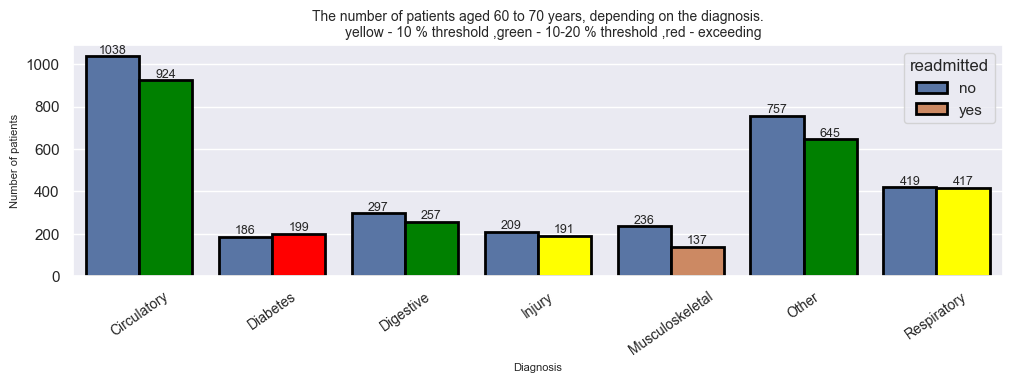

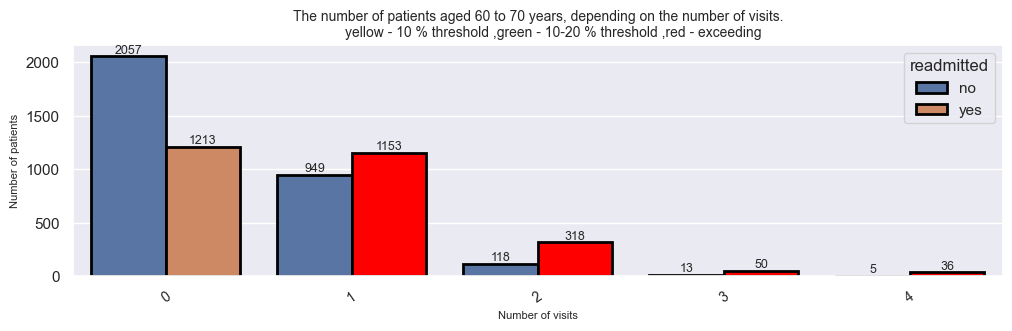

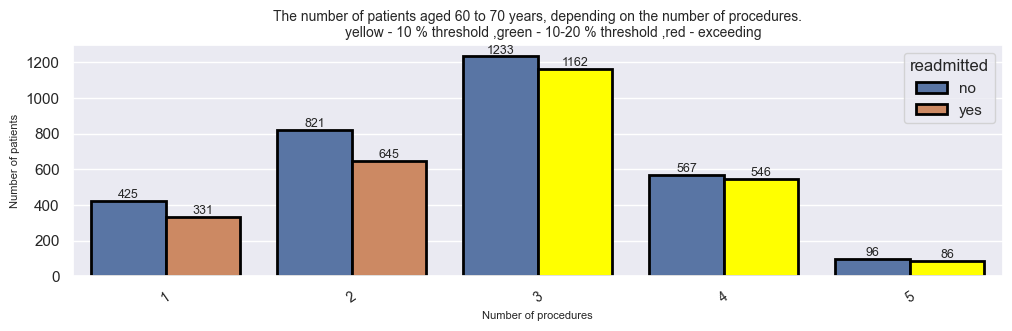

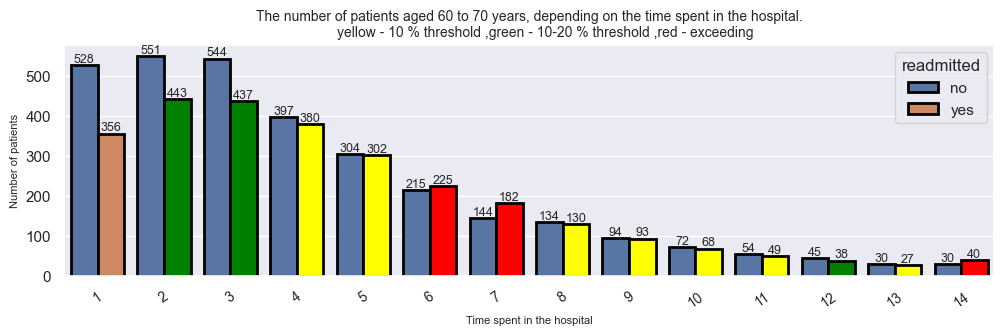

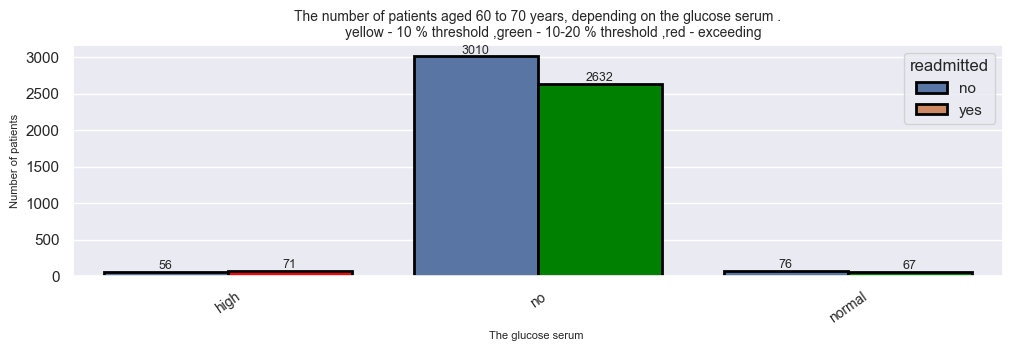

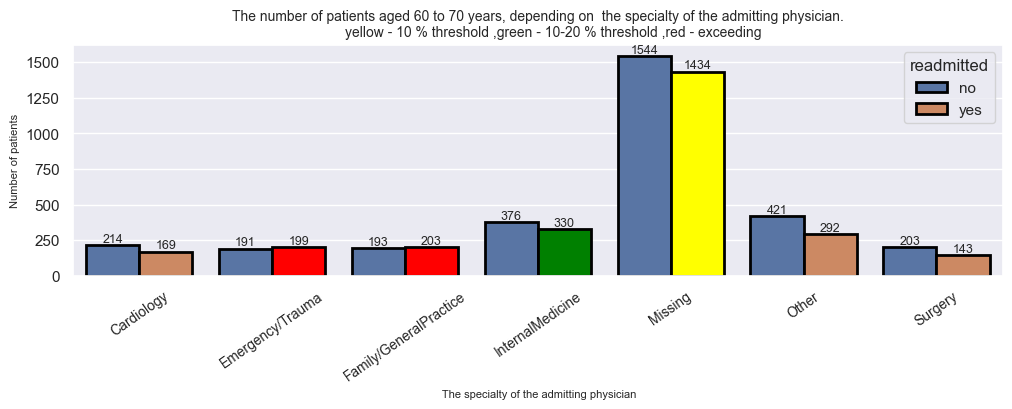

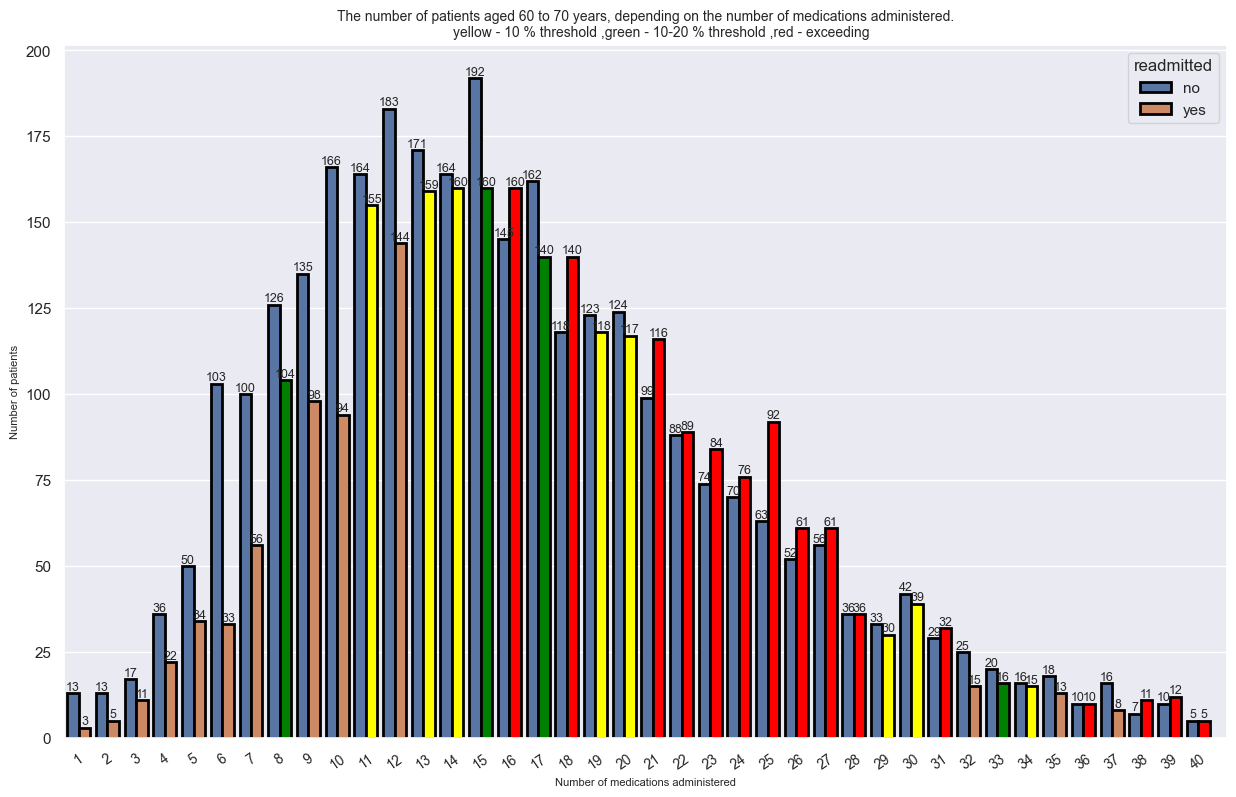

In [222]:
plot('60','70',df70,-.5,40)


This is the second largest age group and here, in addition to Diabetes (in which the percentage of repeated hospitalizations is higher), there are also diagnoses that should be paid attention to Injury and Respiratory.

### Our recommendations.
 - Pay attention to the disease Diabetes and Injury and Respiratory;
 - Pay attention to patients who have applied for various help in the previous year. The chance of their re-hospitalization increases;
 - Pay attention to those patients who have spent more than 4 days in the hospital;




### Age group 70-80 years


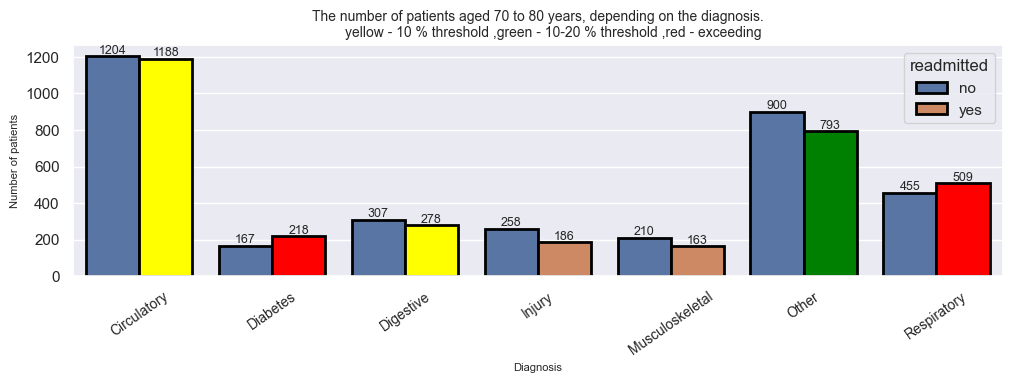

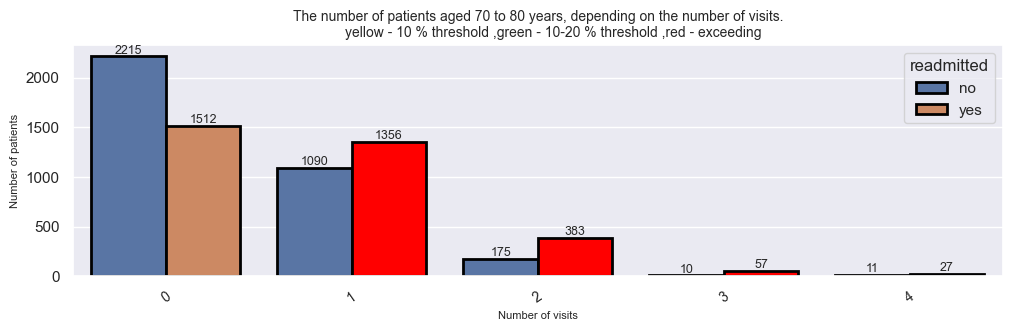

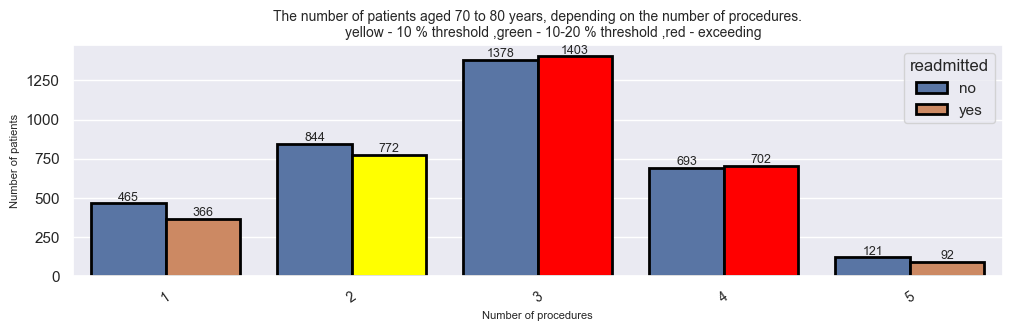

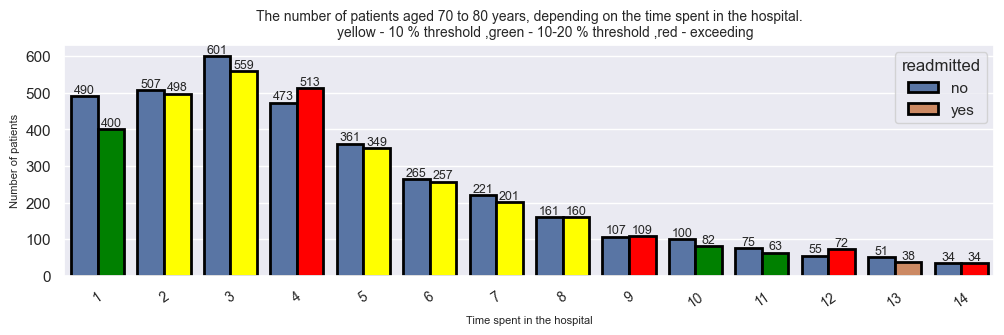

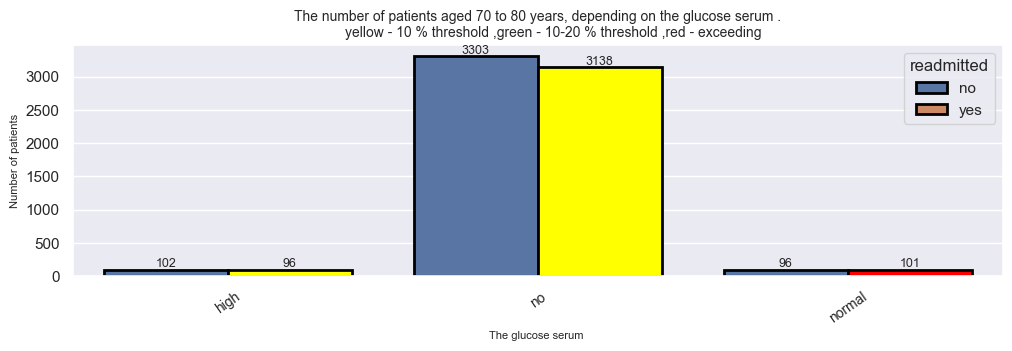

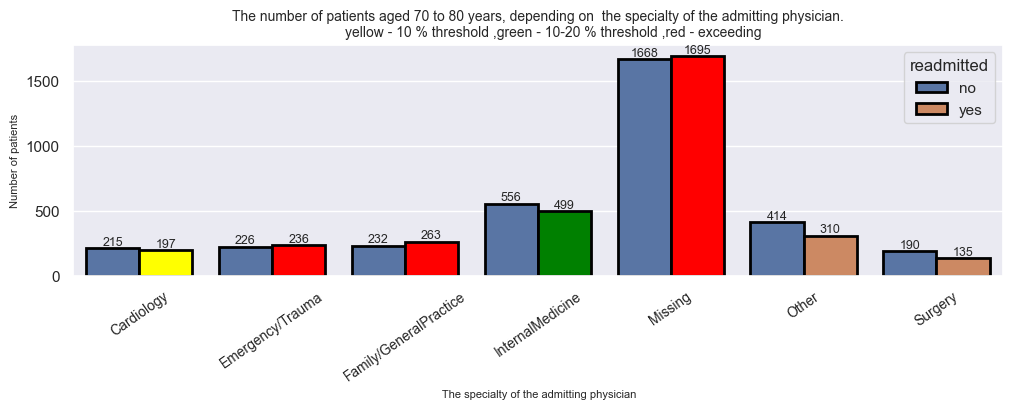

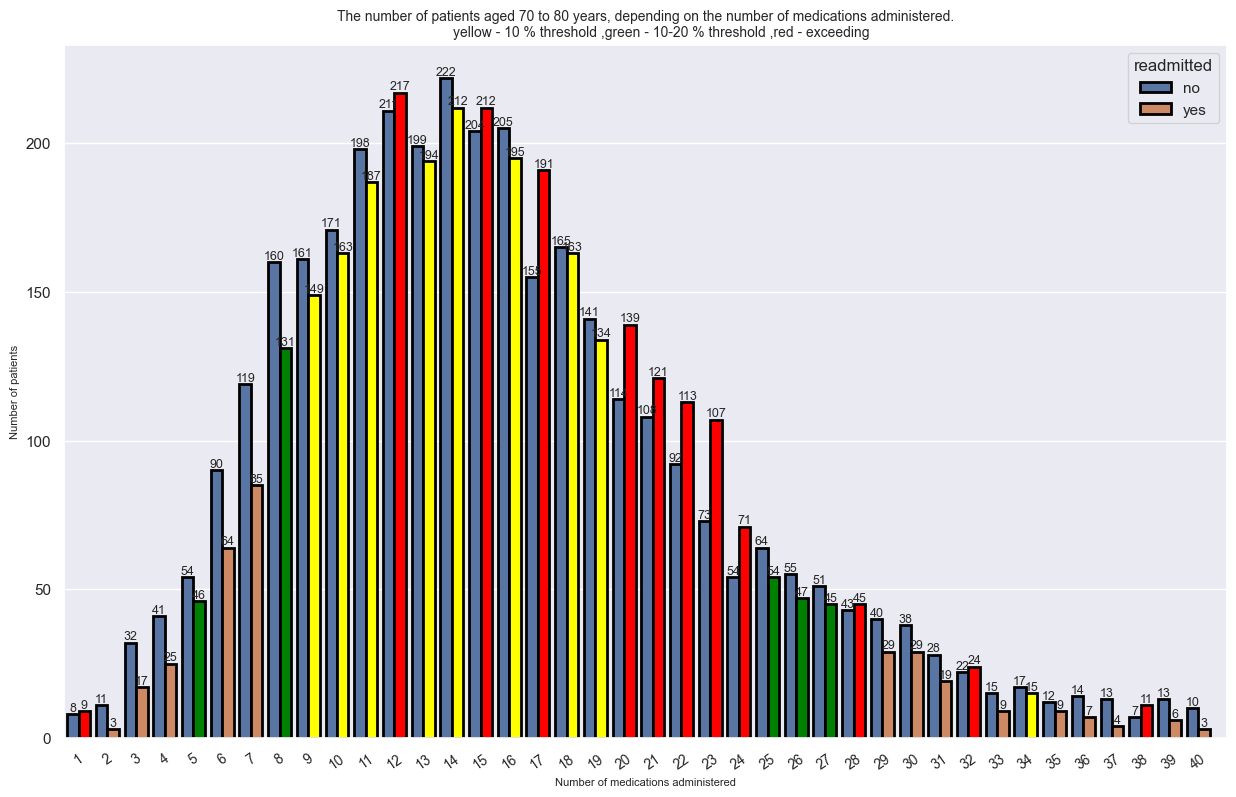

In [223]:
plot('70','80',df80,-.5,40)


This is the most numerous age group and there are two diagnoses in which the percentage of re-hospitalization is high: this is Diabetes and Respiratory. In fact, from the second day spent in the hospital for patients, the risk of repeated hospitalizations increases.



### Age group 80-90 years


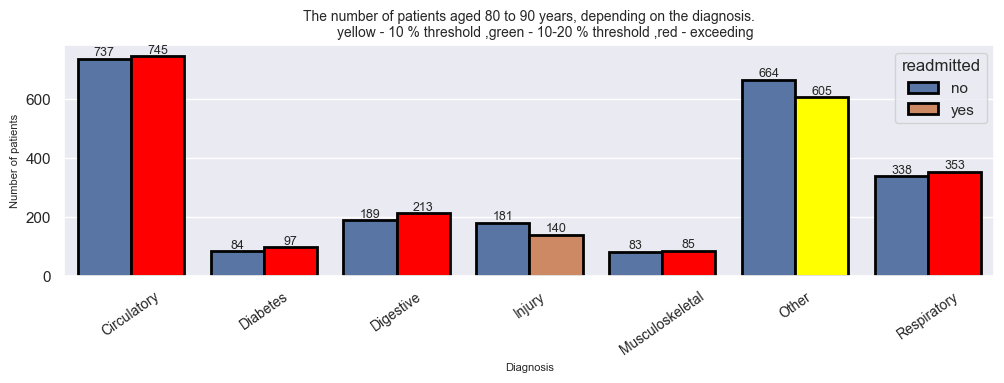

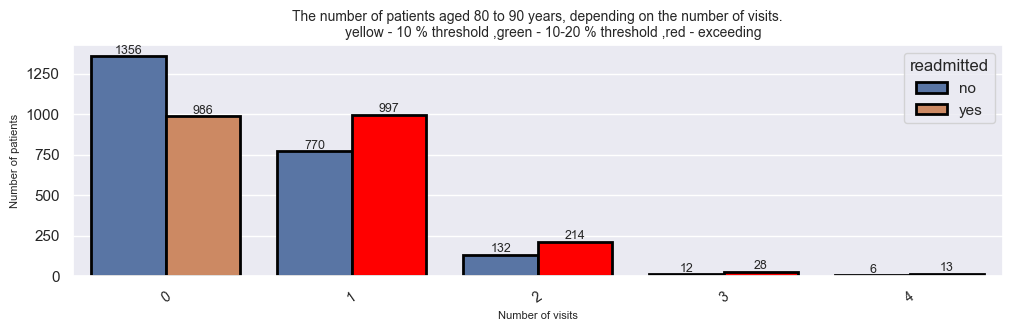

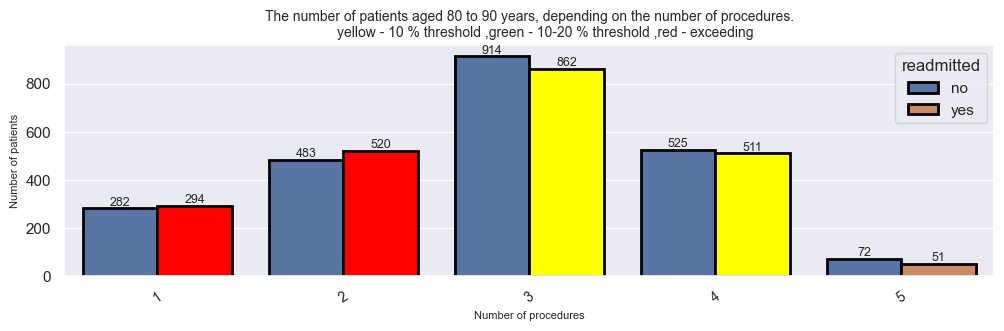

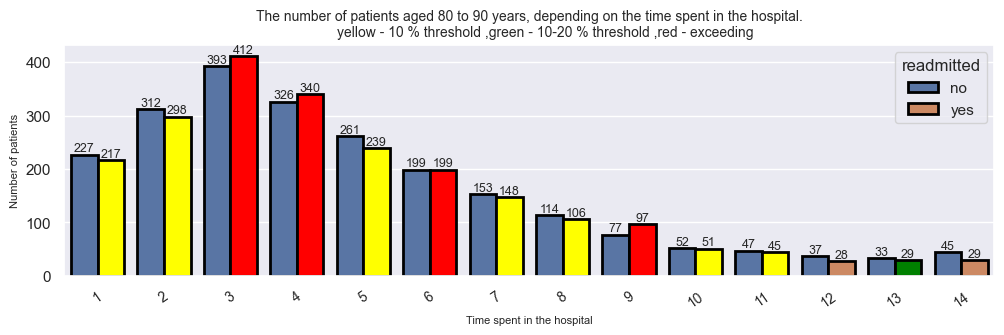

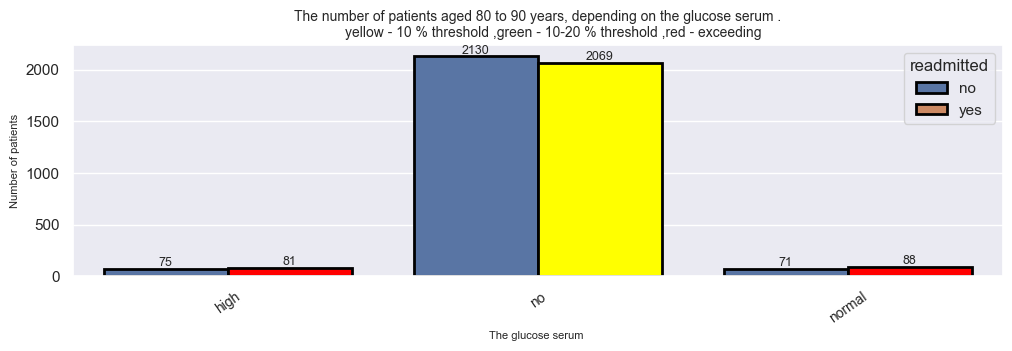

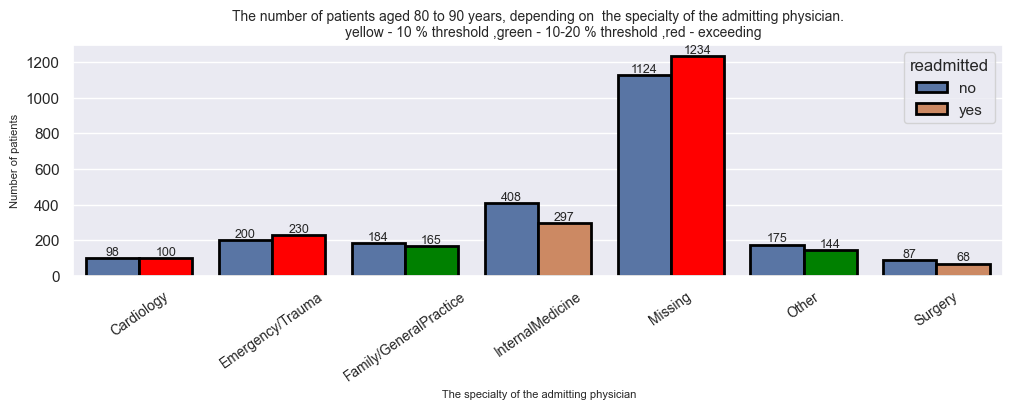

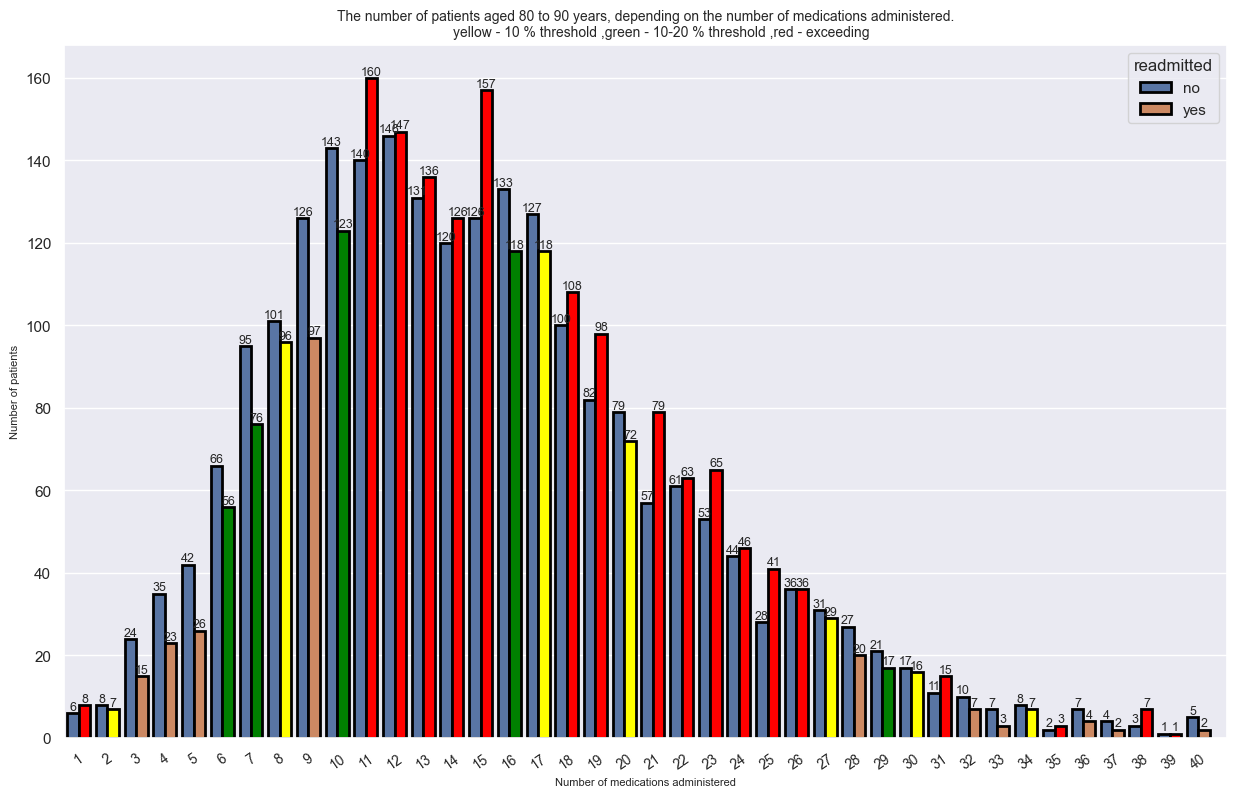

In [224]:
plot('80','90',df90,-.5,40)


In this age group, we already see that the number of repeated hospitalizations is increasing for 5 out of 7 diagnoses, and in fact, from the first day spent in the hospital, they should pay attention to almost every patient.



### Age group 90-100 years


In [225]:
def plot100(age1,age2,df):
    bar("The number of patients aged "+age1+" to "+ age2+" years, depending on the diagnosis.\n\
        yellow - 10 % threshold ,green - 10-20 % threshold ,red - exceeding"\
    ,"Diagnosis","Number of patients",df,"diag_1",'readmitted',12,4)

    bar("The number of patients aged "+age1+" to "+ age2+" years, depending on the number of visits.\n\
        yellow - 10 % threshold ,green - 10-20 % threshold ,red - exceeding"\
    ,"Number of visits","Number of patients",df,"visit",'readmitted',12,4,-.5,2.5)

    bar("The number of patients aged "+age1+" to "+ age2+" years, depending on the number of procedures.\n\
        yellow - 10 % threshold ,green - 10-20 % threshold ,red - exceeding"\
    ,"Number of procedures","Number of patients",df,"n_procedur",'readmitted',12,4)

    bar("The number of patients aged "+age1+" to "+ age2+" years, depending on the time spent in the hospital.\n\
        yellow - 10 % threshold ,green - 10-20 % threshold ,red - exceeding"\
    ,"Time spent in the hospital","Number of patients",df,"time_in_hospital",'readmitted',12,4)

    bar("The number of patients aged "+age1+" to "+ age2+" years, depending on the glucose serum .\n\
        yellow - 10 % threshold ,green - 10-20 % threshold ,red - exceeding"\
    ,"The glucose serum ","Number of patients",df,"glucose_test",'readmitted',12,4)

    bar("The number of patients aged "+age1+" to "+ age2+" years, depending on  the specialty of the admitting physician.\n\
        yellow - 10 % threshold ,green - 10-20 % threshold ,red - exceeding"\
    ," The specialty of the admitting physician","Number of patients",df,"medical_specialty",'readmitted',12,4)


    bar("The number of patients aged "+age1+" to "+ age2+" years, depending on the number of medications administered.\n\
        yellow - 10 % threshold ,green - 10-20 % threshold ,red - exceeding"\
    ,"Number of medications administered","Number of patients",df,"n_medications",'readmitted',15,9,1,29,-.5)

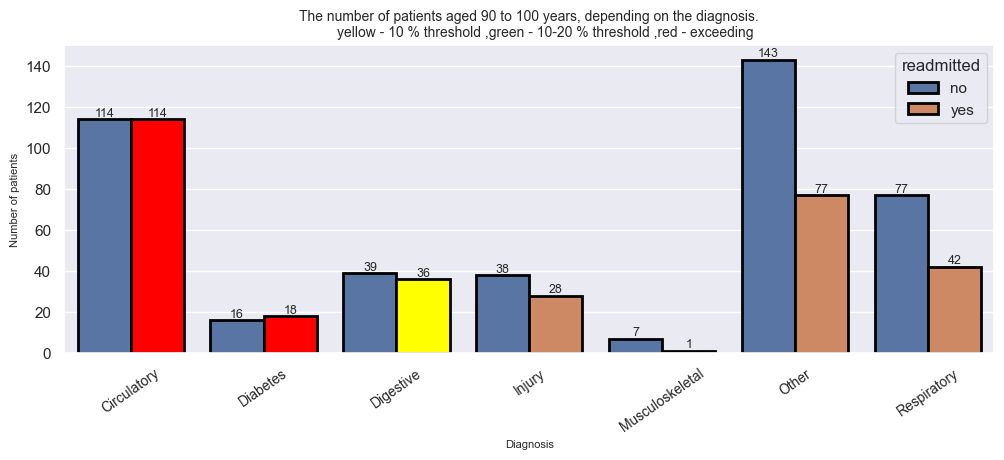

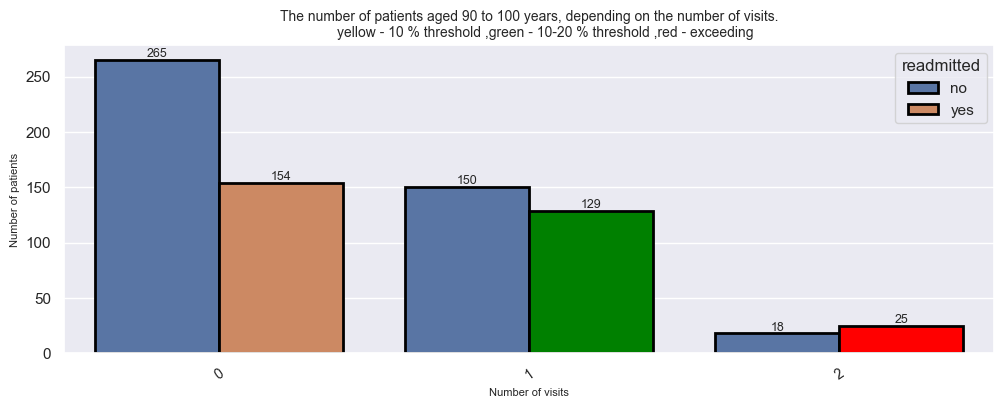

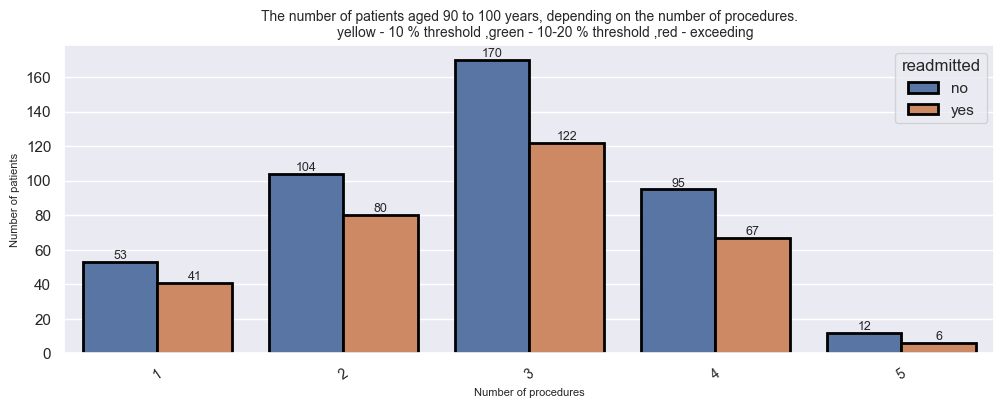

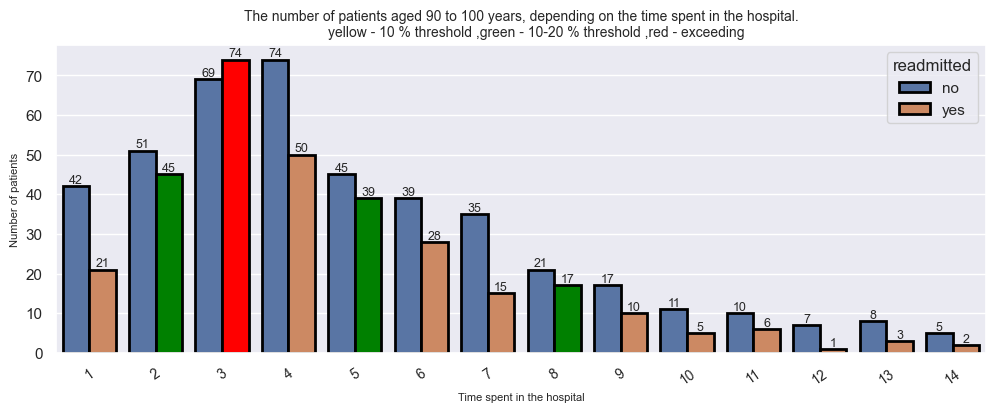

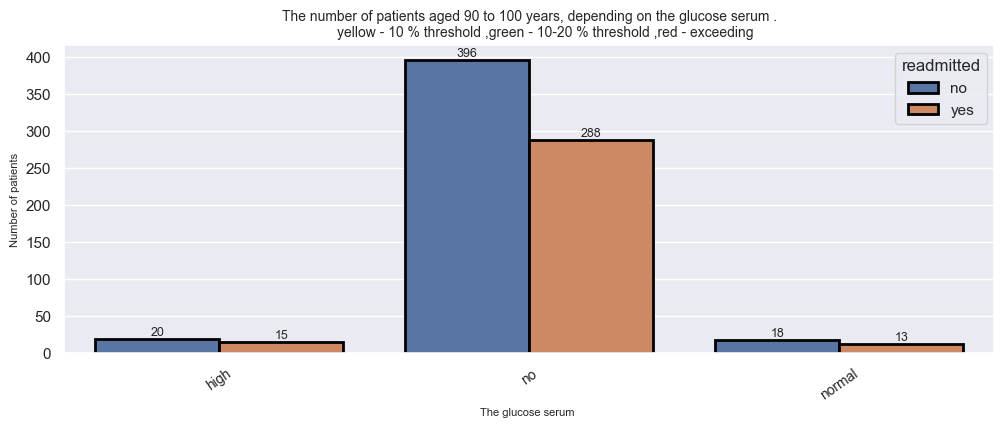

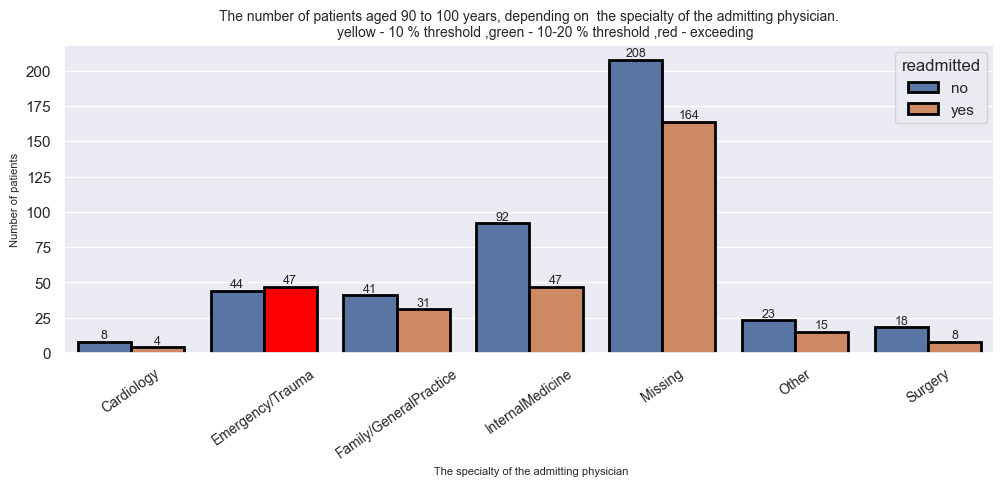

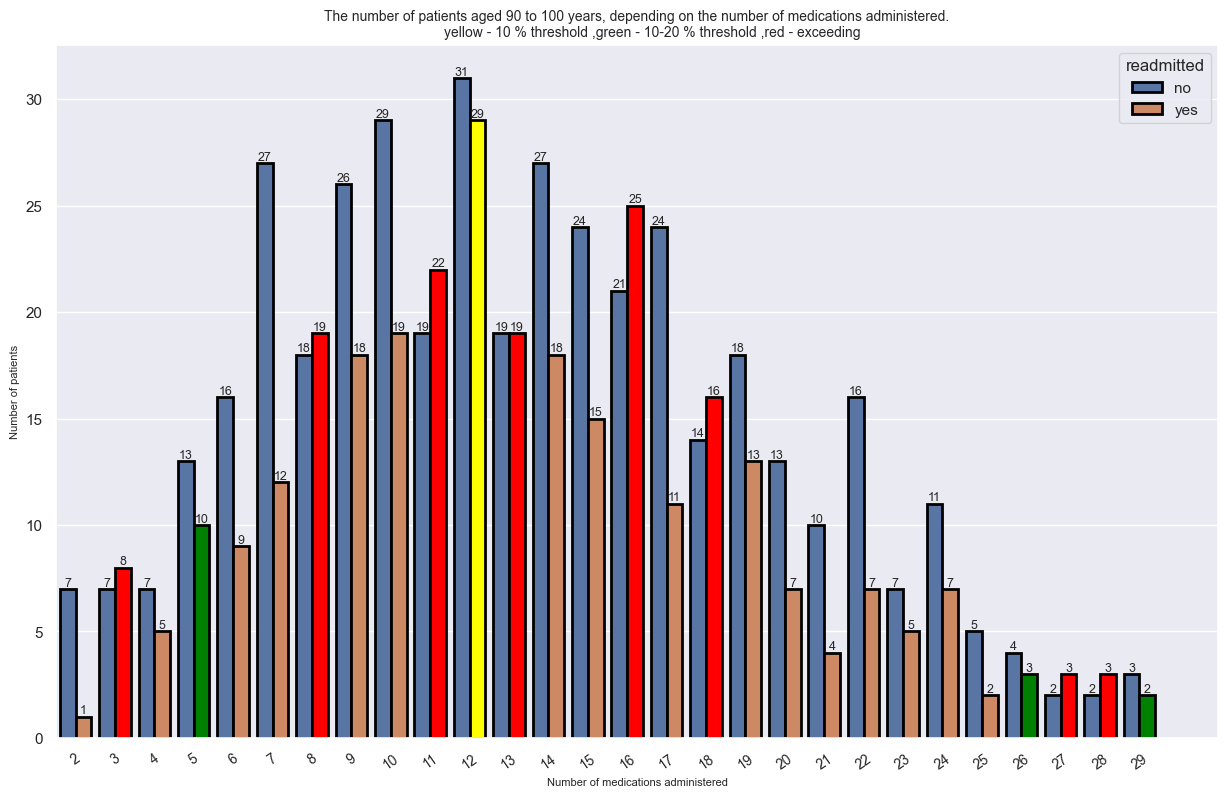

In [226]:
plot100('90','100',df100)



The most age group and it is clear that the smallest. Diabetes and circulatory diseases here are what doctors should spend their attention on.

# Conclusion

### Once again, I apologize for such a large number of identical schedules, but something I did not have enough in this work to diversify them, either time or knowledge.

It became clear that the diagnosis of Diabetes always carries a high risk of re-hospitalization, regardless of the patient's age. But with increasing age, I should carefully look at patients with the following diagnoses:
 - Circulatory;
 - Other;
 - Respirators;
 - Digestive;
 
With increasing age, the risk of re-hospitalization increases for patients who have applied for hospital or outpatient care at least once during a calendar year, and this risk shifts towards a decrease in the time spent in the hospital. For the youngest group, this is 7 days or more and starting from the second day for age-related patients. And in this regard, the risk of re-hospitalization is also shifted by the number of prescribed medications, the older the patient, the fewer medications there is a risk of re-hospitalization.

As I have already said, diabetes, like other chronic diseases, is associated with an increased risk of re-hospitalization. However, diabetes is not always a top priority for hospital health care providers, and without a systematic approach, opportunities for optimizing treatment can be missed.

As noted earlier, glucose test and A1C test were not performed in most cases. Perhaps because effective glycemic control takes several days and the average time spent in the hospital is about 4.5 days.

While doing the work, I read several articles on this topic and that's what I emphasized in them:
Glycemic control may be important when diabetes is a primary diagnosis or is a concomitant disease. Prospective interventional studies aimed at improving glycemic control in the hospital and after discharge are needed to determine whether glycemic control affects the frequency of repeated hospitalizations. At the same time, efforts to reduce repeat hospitalizations should be multifactorial and cover both general and diabetes-specific measures.

In conclusion, the decision to measure the hemoglobin Test in patients with diabetes mellitus is a useful predictor of the frequency of repeated hospitalizations, which may be valuable in developing strategies to reduce the frequency of repeated hospitalizations and the cost of treating patients with diabetes mellitus.



### So which patient groups should the hospital focus its next efforts on?

The diagnosis of diabetes mellitus is always associated with a high risk of re-hospitalization, regardless of the patient's age. But with age, the hospital should carefully look at patients with the following diagnoses:
- Circulatory;
- Other;
- Respirators;
- Digestive;

Patients who have sought inpatient or outpatient care at least once or more during a calendar year also fall into a high risk group for re-hospitalization.

Depending on the age group, you need to pay attention to the number of days spent in the hospital for each age there is a critical number of days in the hospital, after which the risk of repeated hospitalization increases.

Also, the number of prescribed procedures affects the risk of re-hospitalization for each age, it is different, but this is clear with the increase in the number of procedures, the number of re-hospitalized patients increases.

I would also recommend conducting glucose and A1C tests for patients aged 60 - 90 years, at least for two diagnoses: diabetes and circulatory. Since this can subsequently reduce the risk of re-hospitalization.


P.S. Thank you for reading my work to the end! I tried, honestly)))!

## 💪 Competition challenge
Create a report that covers the following:

1. What is the most common primary diagnosis by age group? 
2. Some doctors believe diabetes might play a central role in readmission. Explore the effect of a diabetes diagnosis on readmission rates. 
3. On what groups of patients should the hospital focus their follow-up efforts to better monitor patients with a high probability of readmission?